In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats
from scipy import interpolate
from glob import glob

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from scipy.ndimage import gaussian_filter1d

from utils import *

from scipy.stats import skew, kurtosis

In [3]:
# for plotting
plt.rcParams.update({'font.size': 14})

In [4]:
exp_meta_data_dir = '../meta_data/exp'
exp_data_dir = '../processed_data/exp'
sim_data_dir = '../processed_data/sim'

fig_dir = 'Figures/Supplementary_figures/temporal_dynamics'

# Load data from experiments

In [5]:
# Load meta data
manifest_path = os.path.join(exp_meta_data_dir, 'ecephys_cache_dir_10_31', "manifest.json")
#manifest_path = os.path.join(exp_meta_data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## LFP and CSD

### Load channel depth data

In [6]:
#filename = 'cortical_depth_'+str(session_id)+'.csv'
#loadpath = os.path.join(exp_meta_data_dir, 'probes_cortical_depths', filename)
sessions_df_depth = dict()
loadpaths = sorted(glob(os.path.join(exp_meta_data_dir, 'probes_cortical_depths', '*')))
for loadpath in loadpaths:
    session_id = loadpath.split('/')[-1].split('.')[0].split('_')[-1]
    df_depth = pd.read_csv(loadpath, sep=' ')
    df_depth = df_depth.set_index('id')
    sessions_df_depth[session_id] = df_depth

## Load spike trains

In [7]:
exp_spike_data_dir = os.path.join(exp_data_dir, 'spikes', 'V1')
filename = 'sessions_spike_counts_-1to0pnt5s_white_flash.npy'

loadpath = os.path.join(exp_spike_data_dir, filename)

sessions_spike_trains_V1 = np.load(loadpath, allow_pickle = True)[()]

#### Load meta data

## Load simulation data

In [8]:
selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')

In [9]:
nchan_sim = 23           # Number of channels on probe in simulation

trial_dur_sim = 750      # Duration one trial (ms)
tstim_onset_sim = 250    # Stimulus onset in each trial (ms)
ntrials_sim = 10         # Number of trials

### CSD

## Spikes

In [10]:
def find_all_fir_rates_files_sim(path,filename):
    
    result = dict()
    for root, dirs, files in os.walk(path):
        if len(glob(os.path.join(root,filename)))>0:
            
            fir_rate_file_path = glob(os.path.join(root,filename))[0]
            sim_name = fir_rate_file_path.split('/')[-2]
            fir_rate_file = np.load(fir_rate_file_path, allow_pickle=True)[()]
            result[sim_name] = fir_rate_file
    return result

In [11]:
selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')
timestamps_configs = find_all_fir_rates_files_sim(selected_sims_data_dir, 'timestamps_with_neuron_ids.npy')
sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]

['old_model', 'intermediate_model', 'final_model']


# Make figures

### Sim CSD

In [12]:

step_depth_ticks_sim = 5
step_depth_ticklabels_sim = 200
#nchan_sim = csd_sims[list(csd_sims.keys())[0]]['trial_avg'].shape[0]
nchan_sim = 23
if nchan_sim == 51:
    nchan_sim = int(csd_sims[list(csd_sims.keys())[0]][()]['trial_avg'].shape[0]/2)+1
depth_ticks_sim = np.arange(0, nchan_sim, step_depth_ticks_sim)
depth_ticklabels_sim = -np.arange(0, 1000, step_depth_ticklabels_sim, dtype = 'int')

step_time_ticks_sim = 20
time_tick_stop_sim = 100
time_tick_start_sim = 0
time_ticks_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)
time_ticklabels_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)

In [13]:
sims_labels = dict()

sims_labels['old_model'] = 'Original model'
sims_labels['intermediate_model'] = 'Model w/adjusted\n syn. weights'
sims_labels['final_model'] = 'Final model \nw/feedback and LGN'

sims_colors = dict()
sims_colors['old_model'] = 'b'
sims_colors['intermediate_model'] = 'g'
sims_colors['final_model'] = 'tab:orange'

### Spikes

In [14]:
sims_spike_trains_cell_pops = dict()

In [16]:

for sim_name in sorted(list(timestamps_configs.keys())):
    print(sim_name)

    timestamps_all_cell_pops = timestamps_configs[sim_name]
    cell_names = list(timestamps_all_cell_pops.keys())


    sim_spike_trains_cell_pops = dict()

    for cell_name in cell_names:
        print(cell_name)
        timestamps_cell_pop = timestamps_all_cell_pops[cell_name]

        neuron_ids = timestamps_cell_pop['neuron_ids_of_timestamps']
        trials = timestamps_cell_pop['trials']
        timestamps = timestamps_cell_pop['timestamps']
        #timestamps = timestamps_cell_pop['timestamps_by_trial']
        trial_dur_sim = timestamps_cell_pop['trial_dur']
        #ntrials_sim = len(np.unique(trials))
        '''TODO: Implement general way to determine # of trials (that also works for sims that lasted a bit too long)'''
        ntrials_sim = 10
        timestamps = timestamps % trial_dur_sim
        all_neuron_ids = timestamps_cell_pop['all_neuron_ids_in_pop']

        spike_trains = np.zeros((len(all_neuron_ids), ntrials_sim, trial_dur_sim))
        bins = np.arange(0,trial_dur_sim+1,1)

        for i_nrn, neuron_id in enumerate(all_neuron_ids):
            mask_neuron_id = neuron_ids == neuron_id

            timestamps_nrn = timestamps[mask_neuron_id]

            trials_this_nrn = trials[mask_neuron_id]

            for trial in np.unique(trials_this_nrn):
                if trial >= ntrials_sim:
                    continue
                mask_trial = trials_this_nrn == trial
                timestamps_nrn_this_trial = timestamps_nrn[mask_trial]
                spike_train_trial, _ = np.histogram(timestamps_nrn_this_trial, bins)

                spike_trains[i_nrn, int(trial)] = spike_train_trial

        sim_spike_trains_cell_pops[cell_name] = spike_trains[:,:ntrials_sim]
        
    sims_spike_trains_cell_pops[sim_name] = sim_spike_trains_cell_pops
    
#del timestamps_configs

final_model
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
intermediate_model
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
old_model
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


In [17]:
sims_spike_trains_RS_FS = dict()

for sim_name in sims_spike_trains_cell_pops.keys():

    sim_spike_trains_RS_FS = dict()

    sim_spike_trains_RS_FS['RS'] = []
    sim_spike_trains_RS_FS['FS'] = []

    for cell_pop_name, sim_spike_trains_cell_pop in sims_spike_trains_cell_pops[sim_name].items():
        print(cell_pop_name)
        if cell_pop_name[-5:] != 'Pvalb':
            if len(sim_spike_trains_RS_FS['RS']) == 0:
                sim_spike_trains_RS_FS['RS'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_RS_FS['RS'] = np.concatenate((sim_spike_trains_RS_FS['RS'], 
                                                               sim_spike_trains_cell_pop), axis = 0)
        else:
            if len(sim_spike_trains_RS_FS['FS']) == 0:
                sim_spike_trains_RS_FS['FS'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_RS_FS['FS'] = np.concatenate((sim_spike_trains_RS_FS['FS'], 
                                                               sim_spike_trains_cell_pop), axis = 0)
                           
    sims_spike_trains_RS_FS[sim_name] = sim_spike_trains_RS_FS
    
#del sims_spike_trains_cell_pops

e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


In [18]:
sims_spike_trains_layer_pops = dict()

for sim_name in sims_spike_trains_cell_pops.keys():

    sim_spike_trains_layer_pops = dict()

    sim_spike_trains_layer_pops['RS L2/3'] = []
    sim_spike_trains_layer_pops['RS L4'] = []
    sim_spike_trains_layer_pops['RS L5'] = []
    sim_spike_trains_layer_pops['RS L6'] = []
    sim_spike_trains_layer_pops['FS'] = []

    for cell_pop_name, sim_spike_trains_cell_pop in sims_spike_trains_cell_pops[sim_name].items():
        print(cell_pop_name)#, sim_spike_trains_cell_pops[cell_pop_name].shape)
        #if cell_pop_name[0] == 'e' and cell_pop_name[1] == '2':
        if cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '2':
            if len(sim_spike_trains_layer_pops['RS L2/3']) == 0:
                sim_spike_trains_layer_pops['RS L2/3'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L2/3'] = np.concatenate((sim_spike_trains_layer_pops['RS L2/3'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        #elif cell_pop_name[0] == 'e' and cell_pop_name[1] == '4':
        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '4':
            if len(sim_spike_trains_layer_pops['RS L4']) == 0:
                sim_spike_trains_layer_pops['RS L4'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L4'] = np.concatenate((sim_spike_trains_layer_pops['RS L4'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '5':
            if len(sim_spike_trains_layer_pops['RS L5']) == 0:
                sim_spike_trains_layer_pops['RS L5'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L5'] = np.concatenate((sim_spike_trains_layer_pops['RS L5'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '6':
            if len(sim_spike_trains_layer_pops['RS L6']) == 0:
                sim_spike_trains_layer_pops['RS L6'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L6'] = np.concatenate((sim_spike_trains_layer_pops['RS L6'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] == 'Pvalb':
            if len(sim_spike_trains_layer_pops['FS']) == 0:
                sim_spike_trains_layer_pops['FS'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['FS'] = np.concatenate((sim_spike_trains_layer_pops['FS'], 
                                                               sim_spike_trains_cell_pop), axis = 0)
                
                
    sims_spike_trains_layer_pops[sim_name] = sim_spike_trains_layer_pops
    
#del sims_spike_trains_cell_pops

e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


In [18]:
sim_spike_trains_layer_pops[pop_name].shape

NameError: name 'pop_name' is not defined

### Plot firing rates

In [19]:
loadpaths_unit_depths = sorted(glob(os.path.join(exp_meta_data_dir, 'units_cortical_depth', '*')))

In [20]:

sessions_units_depth = dict()


for file_path in loadpaths_unit_depths:
    properties = dict()
    
    session_id = file_path.split('/')[-1].split('_')[-1].split('.')[0]
    units_depth = pd.read_csv(file_path, sep=' ')
    units_depth = units_depth.set_index('id')
    
    properties['layer'] = units_depth['cortical_layer']
    properties['depth'] = units_depth['cortical_depth']
    
    sessions_units_depth[session_id] = properties

#### Split into layers (but merge inhibitory cells)

In [21]:
sessions_spike_trains_layer_pops = dict()
#for session_id in sessions_units_dist_top_channel.keys():
for session_id, units_depth in sessions_units_depth.items():
    #units_dist_top_channel = sessions_units_dist_top_channel[session_id]
    session_id = int(session_id)
    
    spike_trains_E23 = []
    spike_trains_E4 = []
    spike_trains_E5 = []
    spike_trains_E6 = []
    
    spike_trains_I = []
    
    
    if session_id in sessions_spike_trains_V1.keys():
        for unit_type in sessions_spike_trains_V1[session_id].keys():
            spike_trains = sessions_spike_trains_V1[session_id][unit_type]

            for i_unit, unit_id in enumerate(spike_trains.unit_id.values):
                spike_train = spike_trains[:,:,i_unit]
                #unit_dist_top_channel = units_dist_top_channel[unit_id]
                layer_label = units_depth['layer'][unit_id]

                if layer_label == 2:
                    # L23
                    if unit_type == 'exc':
                        spike_trains_E23.append(spike_train.values)
                elif layer_label == 4:
                    if unit_type == 'exc':
                        spike_trains_E4.append(spike_train.values)
                elif layer_label == 5:
                    if unit_type == 'exc':
                        spike_trains_E5.append(spike_train.values)
                elif layer_label == 6:
                    if unit_type == 'exc':
                        spike_trains_E6.append(spike_train.values)
                        
                if unit_type == 'inh':
                    spike_trains_I.append(spike_train.values)

        spike_trains_layer_pops = dict()

        spike_trains_layer_pops['RS L2/3'] = np.array(spike_trains_E23)
        spike_trains_layer_pops['RS L4'] = np.array(spike_trains_E4)
        spike_trains_layer_pops['RS L5'] = np.array(spike_trains_E5)
        spike_trains_layer_pops['RS L6'] = np.array(spike_trains_E6)
        spike_trains_layer_pops['FS'] = np.array(spike_trains_I)

        sessions_spike_trains_layer_pops[session_id] = spike_trains_layer_pops
        

## Calculate moments of peak firing rate and latencies to peak distributions across cells in layers

### For experiments

In [22]:
#kernel_window_width = 5 # ms
#k = np.ones((kernel_window_width))

tstim_onset = 1000

sessions_peak_fir_rate = dict()
sessions_lat_peak_fir_rate = dict()
sessions_1st_mom = dict()
sessions_2nd_mom = dict()
sessions_3rd_mom = dict()
sessions_4th_mom = dict()

sessions_1st_mom_lat = dict()
sessions_2nd_mom_lat = dict()
sessions_3rd_mom_lat = dict()
sessions_4th_mom_lat = dict()
for session_id in list(sessions_spike_trains_layer_pops.keys()):
    peak_fir_rate_pops = dict()
    lat_to_peak_pops = dict()
    
    fst_mom_pops = dict()
    snd_mom_pops = dict()
    trd_mom_pops = dict()
    frt_mom_pops = dict()
    
    fst_mom_lat_pops = dict()
    snd_mom_lat_pops = dict()
    trd_mom_lat_pops = dict()
    frt_mom_lat_pops = dict()
    for pop_name in sessions_spike_trains_layer_pops[session_id].keys():
        session_spike_trains_layer_pops = sessions_spike_trains_layer_pops[session_id][pop_name]
        if len(session_spike_trains_layer_pops) < 10:
            continue
        
        fir_rate_cells_plot = np.mean(session_spike_trains_layer_pops[:,:,tstim_onset:tstim_onset+100], axis = 1)*1E3
        fir_rate_cells_plot = gaussian_filter(fir_rate_cells_plot, sigma = (0,2))
        #R = ss.lfilter(k, 1, fir_rate_cells_plot, axis=1)
        
        #peak_fir_rate_pops[pop_name] = np.max(R, axis = 1)
        peak_fir_rate_pops[pop_name] = np.max(fir_rate_cells_plot, axis = 1)
        
        fst_mom_pops[pop_name] = np.mean(peak_fir_rate_pops[pop_name])
        snd_mom_pops[pop_name] = np.std(peak_fir_rate_pops[pop_name])
        trd_mom_pops[pop_name] = skew(peak_fir_rate_pops[pop_name])
        frt_mom_pops[pop_name] = kurtosis(peak_fir_rate_pops[pop_name])
        
        #if 'L2/3' in pop_name or 'L4' in pop_name:
        #    print(session_id, pop_name, np.any(fir_rate_cells_plot, axis = 1), np.sum(np.any(fir_rate_cells_plot, axis = 1)), '\n')
        
        lat_to_peak_pops[pop_name] = np.argmax(fir_rate_cells_plot, axis = 1)[np.any(fir_rate_cells_plot, axis = 1)]
        
        if len(lat_to_peak_pops[pop_name]) < 5:
            continue
        fst_mom_lat_pops[pop_name] = np.mean(lat_to_peak_pops[pop_name])
        snd_mom_lat_pops[pop_name] = np.std(lat_to_peak_pops[pop_name])
        trd_mom_lat_pops[pop_name] = skew(lat_to_peak_pops[pop_name])
        frt_mom_lat_pops[pop_name] = kurtosis(lat_to_peak_pops[pop_name])
        
    sessions_peak_fir_rate[session_id] = peak_fir_rate_pops
    sessions_lat_peak_fir_rate[session_id] = lat_to_peak_pops
    
    sessions_1st_mom[session_id] = fst_mom_pops
    sessions_2nd_mom[session_id] = snd_mom_pops
    sessions_3rd_mom[session_id] = trd_mom_pops
    sessions_4th_mom[session_id] = frt_mom_pops
    
    sessions_1st_mom_lat[session_id] = fst_mom_lat_pops
    sessions_2nd_mom_lat[session_id] = snd_mom_lat_pops
    sessions_3rd_mom_lat[session_id] = trd_mom_lat_pops
    sessions_4th_mom_lat[session_id] = frt_mom_lat_pops

### For simulations

In [23]:
sims_1st_mom = dict()
sims_2nd_mom = dict()
sims_3rd_mom = dict()
sims_4th_mom = dict()

sims_1st_mom_lat = dict()
sims_2nd_mom_lat = dict()
sims_3rd_mom_lat = dict()
sims_4th_mom_lat = dict()
    
for sim_name in sims_spike_trains_layer_pops.keys():
    fst_mom_pops = dict()
    snd_mom_pops = dict()
    trd_mom_pops = dict()
    frt_mom_pops = dict()
    
    fst_mom_lat_pops = dict()
    snd_mom_lat_pops = dict()
    trd_mom_lat_pops = dict()
    frt_mom_lat_pops = dict()
    for pop_name in sims_spike_trains_layer_pops[sim_name].keys():
        fir_rate_sim = np.mean(sims_spike_trains_layer_pops[sim_name][pop_name][:,:,tstim_onset_sim:tstim_onset_sim+100], axis = 1)*1E3
        fir_rate_sim = gaussian_filter(fir_rate_sim, sigma = (0,2))
        
        peak_fir_rate_pops[pop_name] = np.max(fir_rate_sim, axis = 1)
        
        fst_mom_pops[pop_name] = np.mean(peak_fir_rate_pops[pop_name])
        snd_mom_pops[pop_name] = np.std(peak_fir_rate_pops[pop_name])
        trd_mom_pops[pop_name] = skew(peak_fir_rate_pops[pop_name])    
        frt_mom_pops[pop_name] = kurtosis(peak_fir_rate_pops[pop_name])
        
        lat_to_peak_pops[pop_name] = np.argmax(fir_rate_sim, axis = 1)[np.any(fir_rate_sim, axis = 1)]
        
        fst_mom_lat_pops[pop_name] = np.mean(lat_to_peak_pops[pop_name])
        snd_mom_lat_pops[pop_name] = np.std(lat_to_peak_pops[pop_name])
        trd_mom_lat_pops[pop_name] = skew(lat_to_peak_pops[pop_name])    
        frt_mom_lat_pops[pop_name] = kurtosis(lat_to_peak_pops[pop_name])
        
    sims_1st_mom[sim_name] = fst_mom_pops
    sims_2nd_mom[sim_name] = snd_mom_pops
    sims_3rd_mom[sim_name] = trd_mom_pops
    sims_4th_mom[sim_name] = frt_mom_pops
    
    sims_1st_mom_lat[sim_name] = fst_mom_lat_pops
    sims_2nd_mom_lat[sim_name] = snd_mom_lat_pops
    sims_3rd_mom_lat[sim_name] = trd_mom_lat_pops
    sims_4th_mom_lat[sim_name] = frt_mom_lat_pops
    

#### Rearrange data for boxplots

In [24]:
pops_1st_mom = dict()
pops_2nd_mom = dict()
pops_3rd_mom = dict()
pops_4th_mom = dict()

pops_1st_mom_lat = dict()
pops_2nd_mom_lat = dict()
pops_3rd_mom_lat = dict()
pops_4th_mom_lat = dict()

for session_id in sessions_1st_mom.keys():
    for pop_name in sessions_1st_mom[session_id].keys():
        if pop_name not in pops_1st_mom.keys():
            pops_1st_mom[pop_name] = []
        pops_1st_mom[pop_name].append(sessions_1st_mom[session_id][pop_name])
        
        if pop_name not in pops_2nd_mom.keys():
            pops_2nd_mom[pop_name] = []
        pops_2nd_mom[pop_name].append(sessions_2nd_mom[session_id][pop_name])
        
        if pop_name not in pops_3rd_mom.keys():
            pops_3rd_mom[pop_name] = []
        pops_3rd_mom[pop_name].append(sessions_3rd_mom[session_id][pop_name])
        
        if pop_name not in pops_4th_mom.keys():
            pops_4th_mom[pop_name] = []
        pops_4th_mom[pop_name].append(sessions_4th_mom[session_id][pop_name])
        
for session_id in sessions_1st_mom_lat.keys():
    for pop_name in sessions_1st_mom_lat[session_id].keys():
        
        if pop_name not in pops_1st_mom_lat.keys():
            pops_1st_mom_lat[pop_name] = []
        pops_1st_mom_lat[pop_name].append(sessions_1st_mom_lat[session_id][pop_name])
        
        if pop_name not in pops_2nd_mom_lat.keys():
            pops_2nd_mom_lat[pop_name] = []
        pops_2nd_mom_lat[pop_name].append(sessions_2nd_mom_lat[session_id][pop_name])
        
        if pop_name not in pops_3rd_mom_lat.keys():
            pops_3rd_mom_lat[pop_name] = []
        pops_3rd_mom_lat[pop_name].append(sessions_3rd_mom_lat[session_id][pop_name])
        
        if pop_name not in pops_4th_mom_lat.keys():
            pops_4th_mom_lat[pop_name] = []
        pops_4th_mom_lat[pop_name].append(sessions_4th_mom_lat[session_id][pop_name])
        
pops_moms = dict()
pops_moms['1st moment'] = pops_1st_mom
pops_moms['2nd moment'] = pops_2nd_mom
pops_moms['3rd moment'] = pops_3rd_mom
pops_moms['4th moment'] = pops_4th_mom

pops_moms_lat = dict()
pops_moms_lat['1st moment'] = pops_1st_mom_lat
pops_moms_lat['2nd moment'] = pops_2nd_mom_lat
pops_moms_lat['3rd moment'] = pops_3rd_mom_lat
pops_moms_lat['4th moment'] = pops_4th_mom_lat

### Plot distribution of moments for experiments and for simulations

#### For magnitude of peak

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


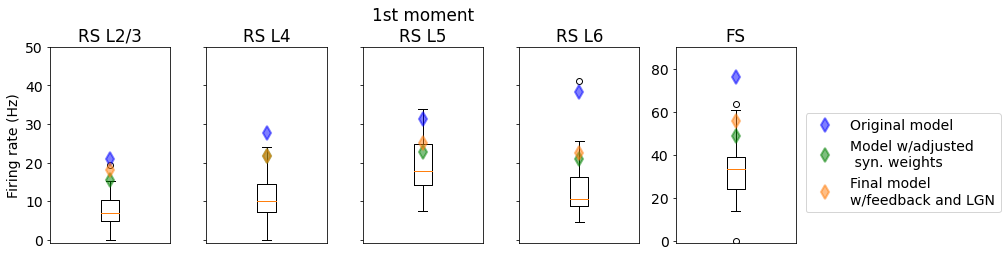

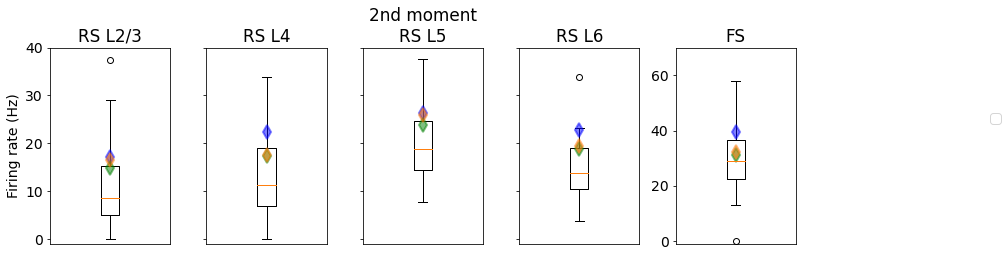

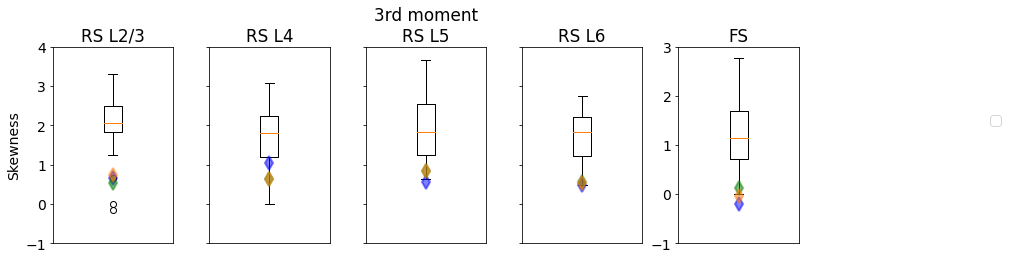

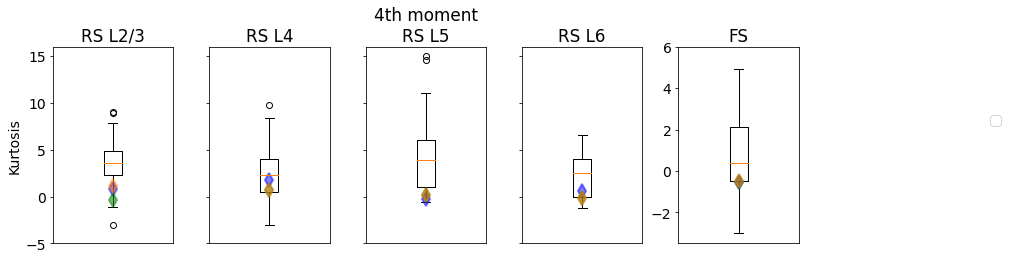

In [25]:

for imom, mom_name in enumerate(pops_moms.keys()):
    pops_mom = pops_moms[mom_name]
    fig, axes = plt.subplots(ncols = 5, figsize = (14,3.5), sharey = False, sharex = True)
    
    for ipop, pop_name in enumerate(sorted(pops_mom.keys())):
        if 'FS' in pop_name:
            iplot = -1
            ax = axes[iplot]
            if '1st' in mom_name:
                ax.set_ylim([-1,90])
            elif '2nd' in mom_name:
                ax.set_ylim([-1,70])
                if '2/3' in pop_name:
                    ax.set_ylabel('Firing rate (Hz)')
            elif '3rd' in mom_name:
                ax.set_ylim([-1,3])
            elif '4th' in mom_name:
                ax.set_ylim([-3.5,6])
        else:
            iplot = ipop-1
            ax = axes[iplot]
            if '1st' in mom_name:
                ax.set_ylim([-1,50])
                if '2/3' in pop_name:
                    ax.set_ylabel('Firing rate (Hz)')
            elif '2nd' in mom_name:
                ax.set_ylim([-1,40])
                if '2/3' in pop_name:
                    ax.set_ylabel('Firing rate (Hz)')
            elif '3rd' in mom_name:
                ax.set_ylim([-1,4])
                if '2/3' in pop_name:
                    ax.set_ylabel('Skewness')
            elif '4th' in mom_name:
                ax.set_ylim([-5,16])
                if '2/3' in pop_name:
                    ax.set_ylabel('Kurtosis')
                
        if 'FS' not in pop_name and '2/3' not in pop_name:
            ax.set_yticklabels([])
        
        ax.boxplot(pops_mom[pop_name])
        
        ax.set_title(pop_name)
        
    for isim, sim_name in enumerate(list(sims_1st_mom.keys())[::-1]):
        for ipop, pop_name in enumerate(sims_1st_mom[sim_name].keys()):
            if 'FS' in pop_name:
                iplot = -1
                ax = axes[iplot]
            else:
                iplot = ipop
                ax = axes[iplot]
            if '1st' in mom_name:
                pop_mom_sim = sims_1st_mom[sim_name][pop_name]
            elif '2nd' in mom_name:
                pop_mom_sim = sims_2nd_mom[sim_name][pop_name]
            elif '3rd' in mom_name:
                pop_mom_sim = sims_3rd_mom[sim_name][pop_name]
            elif '4th' in mom_name:
                pop_mom_sim = sims_4th_mom[sim_name][pop_name]
                
                
            if imom == 0 and iplot == 0:
                label = sims_labels[sim_name]
            else:
                label = None
                
            ax.plot(1, pop_mom_sim, 'd', markersize = 10, label = label, \
                    color = sims_colors[sim_name], alpha = 0.5, markeredgewidth = 2)
    
    fig.legend(bbox_to_anchor = (1.0, 0.6))
    fig.subplots_adjust(wspace = 0.3, left = 0.05, right = 0.79, bottom = 0.05, top = 0.83)
                
    fig.suptitle(mom_name, y = 0.99, x = 0.42)
    
    ax.set_xticks([])
    fig_name = 'peak_mag_dist_'+mom_name[:3]+'_mom_all_model_versions.png'
    
    savepath = os.path.join(fig_dir, fig_name)
    
    #fig.savefig(savepath, facecolor='w')

#### For latency of peak

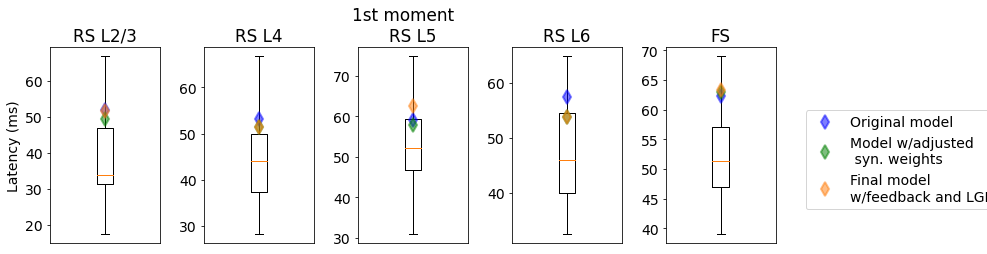

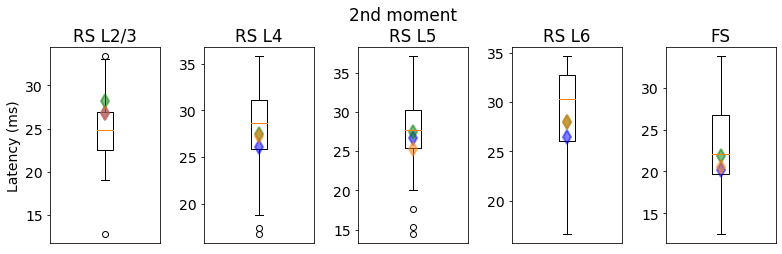

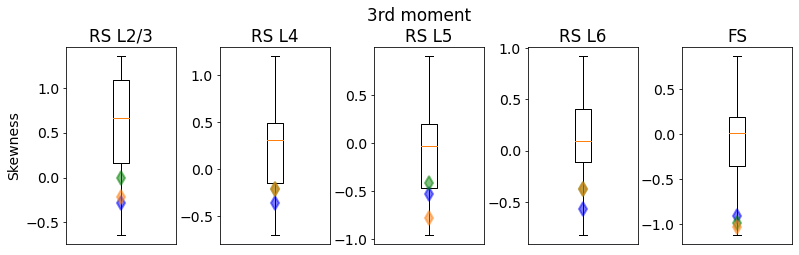

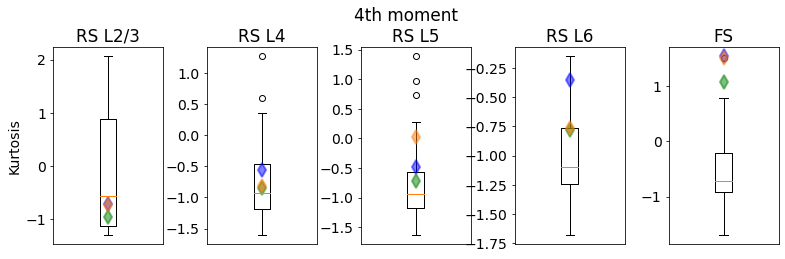

In [26]:

for imom, mom_name in enumerate(pops_moms_lat.keys()):
    pops_mom_lat = pops_moms_lat[mom_name]
    fig, axes = plt.subplots(ncols = 5, figsize = (14,3.5), sharey = False, sharex = True)
    
    for ipop, pop_name in enumerate(sorted(pops_mom_lat.keys())):
        if 'FS' in pop_name:
            iplot = -1
            ax = axes[iplot]
            '''if '1st' in mom_name:
                ax.set_ylim([-1,90])
            elif '2nd' in mom_name:
                ax.set_ylim([-5,3000])
            elif '3rd' in mom_name:
                ax.set_ylim([-1,3])
            elif '4th' in mom_name:
                ax.set_ylim([-3.5,6])'''
        else:
            iplot = ipop-1
            ax = axes[iplot]
            '''if '1st' in mom_name:
                ax.set_ylim([-1,50])
            elif '2nd' in mom_name:
                ax.set_ylim([-1,1500])
            elif '3rd' in mom_name:
                ax.set_ylim([-1,4])
            elif '4th' in mom_name:
                ax.set_ylim([-5,16])'''
        
        ax.boxplot(pops_mom_lat[pop_name])
        
        ax.set_title(pop_name)
        
    for isim, sim_name in enumerate(list(sims_1st_mom_lat.keys())[::-1]):
        for ipop, pop_name in enumerate(sims_1st_mom_lat[sim_name].keys()):
            if 'FS' in pop_name:
                iplot = -1
                ax = axes[iplot]
            else:
                iplot = ipop
                ax = axes[iplot]
            if '1st' in mom_name:
                pop_mom_sim_lat = sims_1st_mom_lat[sim_name][pop_name]
                if '2/3' in pop_name:
                    ax.set_ylabel('Latency (ms)')
            elif '2nd' in mom_name:
                pop_mom_sim_lat = sims_2nd_mom_lat[sim_name][pop_name]
                if '2/3' in pop_name:
                    ax.set_ylabel('Latency (ms)')
            elif '3rd' in mom_name:
                pop_mom_sim_lat = sims_3rd_mom_lat[sim_name][pop_name]
                if '2/3' in pop_name:
                    ax.set_ylabel('Skewness')
            elif '4th' in mom_name:
                pop_mom_sim_lat = sims_4th_mom_lat[sim_name][pop_name]
                if '2/3' in pop_name:
                    ax.set_ylabel('Kurtosis')
                
            if imom == 0 and iplot == 0:
                label = sims_labels[sim_name]
            else:
                label = None
                
            ax.plot(1, pop_mom_sim_lat, 'd', markersize = 10, label = label, \
                    color = sims_colors[sim_name], alpha = 0.5, markeredgewidth = 2)
            
    if imom == 0:
        fig.legend(bbox_to_anchor = (1.0, 0.6))
                
    fig.subplots_adjust(wspace = 0.4, left = 0.07, right = 0.79, bottom = 0.05, top = 0.83)
                
    fig.suptitle(mom_name, y = 0.99, x = 0.42)
    
    ax.set_xticks([])
    
    fig_name = 'peak_lat_dist_'+mom_name[:3]+'_mom_'+sim_name+'.png'
    
    savepath = os.path.join(fig_dir, fig_name)
    
    #fig.savefig(savepath, facecolor='w')

In [26]:
fig_dir

'Figures/Supplementary_figures/temporal_dynamics'

### Relative change in peak firing rates across populations in V1

#### For experiments

In [27]:
tstim_onset = 1000

sessions_1st_mom_RS_FS = dict()
sessions_2nd_mom_RS_FS = dict()
sessions_3rd_mom_RS_FS = dict()
sessions_4th_mom_RS_FS = dict()

for session_id, units_depth in sessions_units_depth.items():
    session_id = int(session_id)
    fst_mom_pops = dict()
    snd_mom_pops = dict()
    trd_mom_pops = dict()
    frt_mom_pops = dict()
    if session_id in sessions_spike_trains_V1.keys():
        for unit_type in sessions_spike_trains_V1[session_id].keys():
            #print(session_id, unit_type, sessions_spike_trains_V1[session_id][unit_type].shape[2])
            if sessions_spike_trains_V1[session_id][unit_type].shape[2] < 10:
                continue
            fir_rate_cells = np.mean(sessions_spike_trains_V1[session_id][unit_type][:,tstim_onset:tstim_onset+100], axis = 0)
            
            peak_fir_rate = fir_rate_cells.max(axis = 0).values
            
            fst_mom_pops[unit_type] = np.mean(peak_fir_rate)
            snd_mom_pops[unit_type] = np.var(peak_fir_rate)
            trd_mom_pops[unit_type] = skew(peak_fir_rate)
            frt_mom_pops[unit_type] = kurtosis(peak_fir_rate)
            
        sessions_1st_mom_RS_FS[session_id] = fst_mom_pops
        sessions_2nd_mom_RS_FS[session_id] = snd_mom_pops
        sessions_3rd_mom_RS_FS[session_id] = trd_mom_pops
        sessions_4th_mom_RS_FS[session_id] = frt_mom_pops
        

#### For simulations

In [28]:
sims_1st_mom_RS_FS = dict()        
for sim_name in sims_spike_trains_RS_FS.keys():
    fst_mom_pops = dict()
    for unit_type in sims_spike_trains_RS_FS[sim_name].keys():
        fir_rates_sim = np.mean(sims_spike_trains_RS_FS[sim_name][unit_type][:,:,tstim_onset_sim:tstim_onset_sim+100]\
                                 , axis = 1)

        peak_fir_rate_sim = np.max(fir_rates_sim, axis = 1)
        
        fst_mom_pops[unit_type] = np.mean(peak_fir_rate_sim)
        
    sims_1st_mom_RS_FS[sim_name] = fst_mom_pops
        

In [29]:
sims_spike_trains_RS_FS.keys()

dict_keys(['final_model', 'intermediate_model', 'old_model'])

### Calculate relative change across populations for first moment

In [41]:
sessions_pops_rel_change = dict()
for session_id in sessions_1st_mom.keys():
    if len(sessions_1st_mom[session_id].keys()) < 2:
        continue
    pops_rel_change = dict()
    for ipop1 in range(len(sessions_1st_mom[session_id].keys())):
        for ipop2 in range(ipop1+1, len(sessions_1st_mom[session_id].keys())):
            #print(ipop1, ipop2)
            pop_name1 = list(sessions_1st_mom[session_id].keys())[ipop1]
            pop_name2 = list(sessions_1st_mom[session_id].keys())[ipop2]
            
            mag_pop1 = sessions_1st_mom[session_id][pop_name1]
            mag_pop2 = sessions_1st_mom[session_id][pop_name2]
            
            rel_change = ((mag_pop2-mag_pop1)/mag_pop1)*100
            
            print(pop_name1, pop_name2, rel_change)
            #print(session_id, pop_name1, np.round(mag_pop1, 1), \
            #    pop_name2, np.round(mag_pop2, 1), np.round(rel_change, 1))
            
            if np.isnan(rel_change) or 'FS' in pop_name2:
                continue
            
            pops_rel_change[pop_name1+'_'+pop_name2] = rel_change
        
    if len(pops_rel_change.keys()) == 0:
        continue
    sessions_pops_rel_change[session_id] = pops_rel_change
    
sims_pops_rel_change = dict()

for sim_name in sims_1st_mom.keys():
    pops_rel_change = dict()
    for ipop1 in range(len(sims_1st_mom[sim_name].keys())):
        for ipop2 in range(ipop1+1, len(sims_1st_mom[sim_name].keys())):
            
            pop_name1 = list(sims_1st_mom[sim_name].keys())[ipop1]
            pop_name2 = list(sims_1st_mom[sim_name].keys())[ipop2]
            
            mag_pop1 = sims_1st_mom[sim_name][pop_name1]
            mag_pop2 = sims_1st_mom[sim_name][pop_name2]
            
            rel_change = ((mag_pop2-mag_pop1)/mag_pop1)*100
            
            if np.isnan(rel_change) or 'FS' in pop_name2:
                continue
                
            pops_rel_change[pop_name1+'_'+pop_name2] = rel_change
            
    sims_pops_rel_change[sim_name] = pops_rel_change

RS L4 RS L5 57.00384644132416
RS L4 RS L6 -37.72468385957364
RS L4 FS 135.8372300434991
RS L5 RS L6 -60.3351653147555
RS L5 FS 50.2111160898448
RS L6 FS 278.7009760202631
RS L4 FS 88.49796294366136
RS L2/3 RS L4 nan
RS L2/3 FS nan
RS L4 FS nan
RS L4 FS 52.204691853676565
RS L4 RS L5 -4.392136097333791
RS L4 FS 35.07153610344198
RS L5 FS 41.27659649519191
RS L5 RS L6 -65.74180103031593
RS L5 FS 2.2762139067789953
RS L6 FS 198.54521540167883
RS L2/3 RS L4 120.25857152620559
RS L2/3 RS L5 259.0174056531425
RS L2/3 RS L6 307.0527530669826
RS L2/3 FS 663.3431559339946
RS L4 RS L5 62.998154017551066
RS L4 RS L6 84.80677062710944
RS L4 FS 246.56683308380337
RS L5 RS L6 13.37967091775168
RS L5 FS 112.6200969407827
RS L6 FS 87.52929446675004
RS L4 RS L5 62.09447240482893
RS L4 RS L6 -33.09727900704197
RS L4 FS 209.1786016081097
RS L5 RS L6 -58.7260934932628
RS L5 FS 90.73975627986867
RS L6 FS 362.13158003043384
RS L4 RS L5 54.17134218390527
RS L4 RS L6 37.21720693592841
RS L4 FS 426.13339467518

/Users/atleeskelandrimehaug/opt/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


#### Rearrange data for boxplot

In [42]:
pops_rel_change = dict()

for session_id in sessions_pops_rel_change.keys():
    for pop_names in sessions_pops_rel_change[session_id].keys():
        rel_change = sessions_pops_rel_change[session_id][pop_names]
        
        if pop_names not in pops_rel_change.keys():
            pops_rel_change[pop_names] = []
        pops_rel_change[pop_names].append(rel_change)

#### Plot relative change in peak firing rates between populations

In [43]:

pop_names.split('_')[1]

'RS L5'

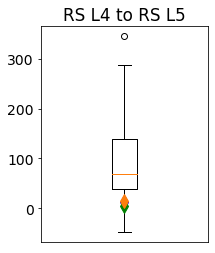

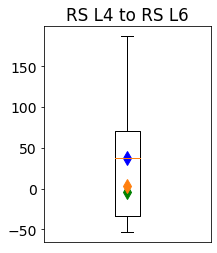

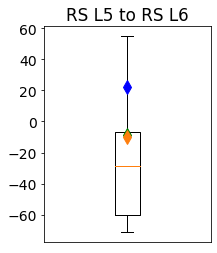

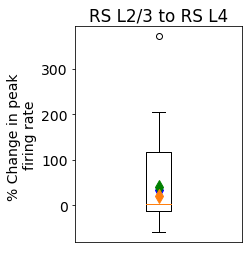

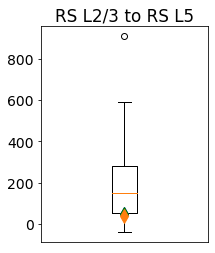

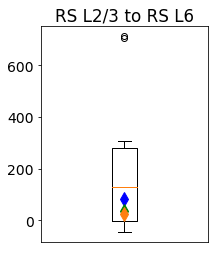

In [44]:
for pop_names in pops_rel_change.keys():
    pops_rel_change_plot = pops_rel_change[pop_names]
    
    fig, ax = plt.subplots(figsize = (4,4))
    ax.boxplot(pops_rel_change_plot)
    ax.set_title(pop_names.split('_')[0]+' to '+ pop_names.split('_')[1])
    
    for sim_name in list(sims_pops_rel_change.keys())[::-1]:
        sim_pops_rel_change = sims_pops_rel_change[sim_name][pop_names]
        
        ax.plot(1, sim_pops_rel_change, 'd', markersize = 10, color = sims_colors[sim_name], label = sims_labels[sim_name])

    if '2/3' in pop_names.split('_')[0] and '4' in pop_names.split('_')[1]:
        ax.set_ylabel('% Change in peak \nfiring rate')
    ax.set_xticks([])
    #fig.legend(bbox_to_anchor = (1.2,0.5))
    
    fig.subplots_adjust(left = 0.32, right = 0.9, bottom = 0.1, top = 0.85)
    
    if '2/3' not in pop_names:
        fig_name = pop_names.split('_')[0]+' to '+ pop_names.split('_')[1]+'_rel_change_fir_rate_dist_'+sim_name+'.png'
    else:
        fig_name = 'RS_L23_to_'+ pop_names.split('_')[1]+'_rel_change_fir_rate_dist_'+sim_name+'.png'
    savepath = os.path.join(fig_dir, fig_name)
    
    fig.savefig(savepath, facecolor='w')

#### Relative change between all RS cells and FS cells

In [45]:
sessions_rel_change_RS_FS = dict()

for session_id in sessions_1st_mom_RS_FS.keys():
    if len(sessions_1st_mom_RS_FS[session_id].keys()) < 2:
        continue
    
    RS_1st_mom = sessions_1st_mom_RS_FS[session_id]['exc']
    FS_1st_mom = sessions_1st_mom_RS_FS[session_id]['inh']
    
    if FS_1st_mom == 0:
        continue
        
    rel_change = (FS_1st_mom-RS_1st_mom)/RS_1st_mom*100
    
    if np.isnan(rel_change):
        continue
    
    sessions_rel_change_RS_FS[session_id] = rel_change
    
sims_rel_change_RS_FS = dict()
for sim_name in sims_1st_mom_RS_FS.keys():
    RS_1st_mom_sim = sims_1st_mom_RS_FS[sim_name]['RS']
    FS_1st_mom_sim = sims_1st_mom_RS_FS[sim_name]['FS']
    
    rel_change = (FS_1st_mom_sim-RS_1st_mom_sim)/RS_1st_mom_sim*100
            
    sims_rel_change_RS_FS[sim_name] = rel_change

In [46]:
sims_rel_change_RS_FS

{'final_model': 111.35468472350163,
 'intermediate_model': 101.0569090264654,
 'old_model': 111.71314040416367}

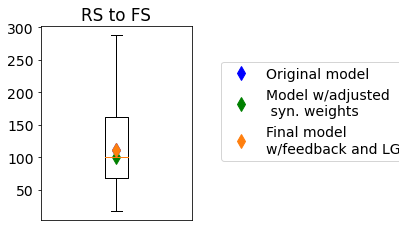

In [48]:
fig, ax = plt.subplots(figsize = (6,3.5))

ax.boxplot(np.array(list(sessions_rel_change_RS_FS.values())))

for sim_name in list(sims_rel_change_RS_FS.keys())[::-1]:
    rel_change = sims_rel_change_RS_FS[sim_name]
    ax.plot(1, rel_change, 'd', markersize = 10, color = sims_colors[sim_name], label = sims_labels[sim_name])
    
    ax.set_title('RS to FS')
    
    #ax.set_ylabel('% Change in peak \nfiring rate')
ax.set_xticks([])

fig.legend(bbox_to_anchor = (0.98, 0.7))
    
fig.subplots_adjust(left = 0.15, right = 0.5, bottom = 0.07, top = 0.84)

fig_name = 'RS_to_FS_rel_change_fir_rate_dist_'+sim_name+'.png'
savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor='w')

### Curvature of rate change

In [36]:
plt.plot(np.diff(fir_rates[icell]))
plt.plot(np.gradient(fir_rates[icell]))

NameError: name 'fir_rates' is not defined

In [625]:
np.max(d_fir_rates, axis = 1).shape

(15,)

In [634]:
np.any(fir_rates, axis = 1)

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

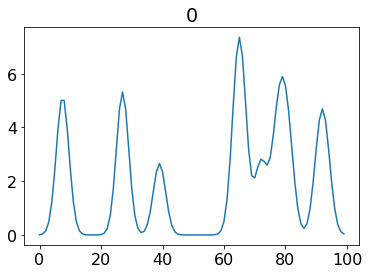

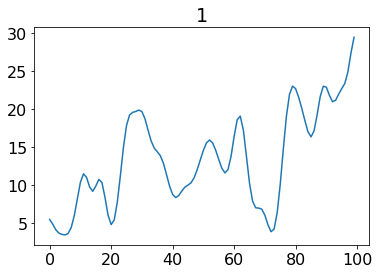

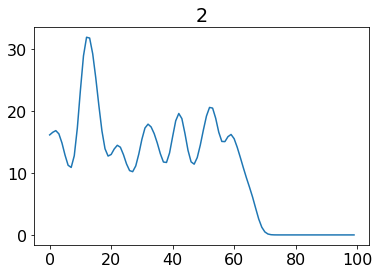

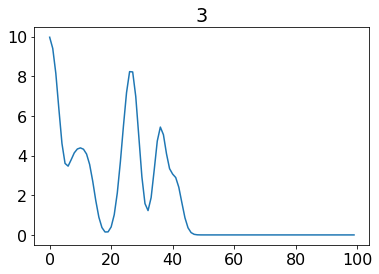

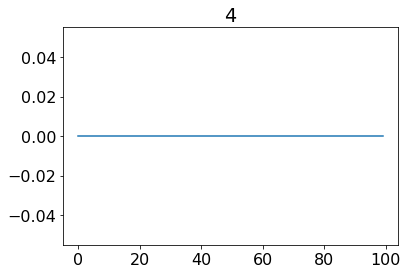

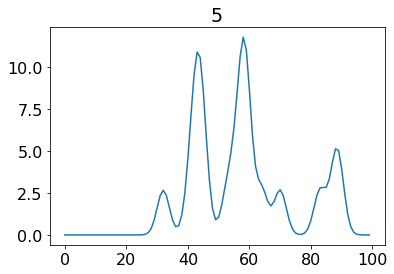

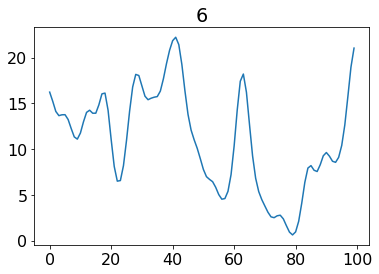

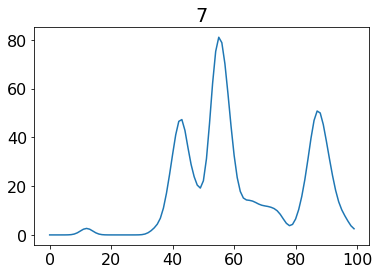

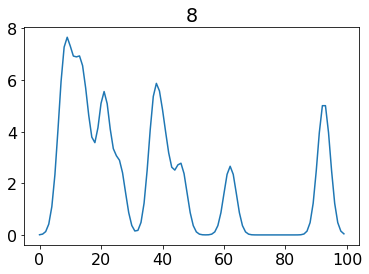

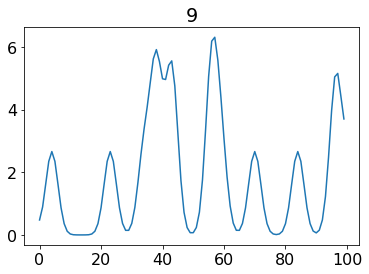

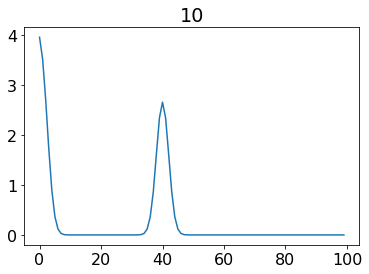

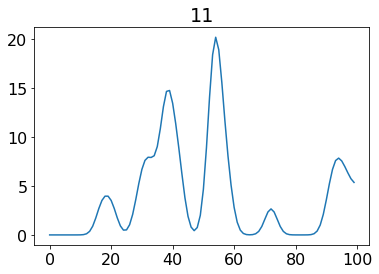

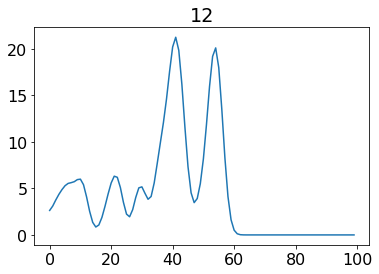

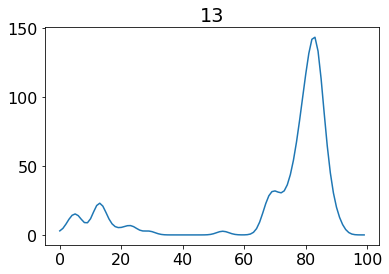

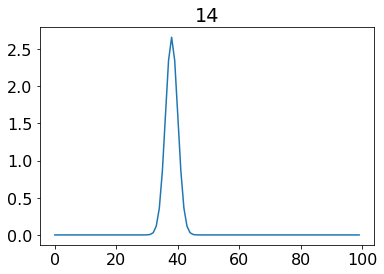

In [636]:
for icell in range(fir_rates.shape[0]):
    plt.figure()
    plt.plot(fir_rates[icell])
    plt.title(icell)

In [37]:
sessions_max_rate_change = dict()
sessions_lat_max_rate_change = dict()

sessions_max_curv = dict()
sessions_lat_max_curv = dict()

sessions_baseline_rate = dict()

tstim_onset = 1000

for session_id in sessions_spike_trains_layer_pops.keys():
    pops_max_rate_change = dict()
    pops_lat_max_rate_change = dict()
    
    pops_max_curv = dict()
    pops_lat_max_curv = dict()
    
    pops_baseline_rate = dict()
    for pop_name in sessions_spike_trains_layer_pops[session_id].keys():
        if len(sessions_spike_trains_layer_pops[session_id][pop_name]) < 10:
            continue
        fir_rates = np.mean(sessions_spike_trains_layer_pops[session_id][pop_name][:,:,tstim_onset:tstim_onset+100],axis = 1)
        fir_rates = gaussian_filter(fir_rates, sigma = (0,2))*1E3

        d_fir_rates = np.diff(fir_rates, n = 1, axis = 1)
        dd_fir_rates = np.diff(d_fir_rates, n = 1, axis = 1)
        ddd_fir_rates = np.diff(dd_fir_rates, n = 1, axis = 1)
        num = ddd_fir_rates
        denom = (1+dd_fir_rates[:,:-1]**2)**(3/2)
        curvature = num/denom
        
        pops_max_curv[pop_name] = np.max(curvature, axis = 1)
        pops_lat_max_curv[pop_name] = np.argmax(curvature, axis = 1)[np.any(fir_rates, axis = 1)]

        pops_max_rate_change[pop_name] = np.max(d_fir_rates, axis = 1)
        pops_lat_max_rate_change[pop_name] = np.argmax(d_fir_rates, axis = 1)[np.any(fir_rates, axis = 1)]
        
        pops_baseline_rate[pop_name] = gaussian_filter1d(np.mean(np.mean(sessions_spike_trains_layer_pops[session_id][pop_name][:,:,:tstim_onset], \
                                        axis = 1), axis = -1)*1E3, sigma = 2)
        
        print(session_id, pop_name, np.argmax(d_fir_rates, axis = 1)[np.any(fir_rates, axis = 1)])

    sessions_max_curv[session_id] = pops_max_rate_change
    sessions_lat_max_curv[session_id] = pops_lat_max_rate_change
    
    sessions_max_rate_change[session_id] = pops_max_curv
    sessions_lat_max_rate_change[session_id] = pops_lat_max_curv
    
    sessions_baseline_rate[session_id] = pops_baseline_rate

715093703 RS L4 [57 40 45 36 97 67 96]
715093703 RS L5 [60 75 96 39 73 40 40 18 65 49 71 27 97 23 75 59 76]
715093703 RS L6 [63 43 27 80 33  4 15 37 62 39 74 51 78]
715093703 FS [61 63 62 79 78 41 38 60  3 45 10 29 57 17 45]
719161530 RS L4 [55 39 53 61 77 65 72 52 93 38 74 26 29 19 97 72]
719161530 FS [80 60 58 95 54 64 39 10  4 21 97 52 53]
721123822 RS L5 [96 90 89 53 76 35 89 59 77 91 69 92 36 64 34 57 66]
743475441 RS L2/3 []
743475441 RS L4 []
743475441 FS []
744228101 RS L4 [54 92 14  4 56 63 55 37 24 92 68]
744228101 FS [49 10 34 34 67 80 86 43 35  9 26 32 35 39]
750749662 RS L4 [96 60 59 18 48 21 49 37 36 41  4 20 32 15 26 36]
750749662 RS L5 [96 46 49 20 40 52 37 55 66 89 53]
750749662 FS [24  6 58 51 46 54 45  7 39 36 66 34 46 66 41 45 32]
751348571 RS L5 [86 45 27 96 94 13 42 69 97 51]
751348571 RS L6 [14 78 11 23 44 48 48 42 93 67 61 96 94]
751348571 FS [60 54 96 52 65 68 69  3 50 14]
754312389 RS L2/3 [14 50 37 24 16 25 12 14 21 32 12 47  7  6 16 86]
754312389 RS L4 [43 2

In [38]:
sims_max_rate_change = dict()
sims_lat_max_rate_change = dict()

sims_max_curv = dict()
sims_lat_max_curv = dict()

sims_baseline_rate = dict()

for sim_name in sims_spike_trains_layer_pops.keys():
    pops_max_rate_change = dict()
    pops_lat_max_rate_change = dict()
    
    pops_max_curv = dict()
    pops_lat_max_curv = dict()
    for pop_name in sims_spike_trains_layer_pops[sim_name].keys():
        fir_rates = np.mean(sims_spike_trains_layer_pops[sim_name][pop_name][:,:,tstim_onset_sim:tstim_onset_sim+100],\
                           axis = 1)
        
        fir_rates = gaussian_filter(fir_rates, sigma = (0,2))*1E3
        
        d_fir_rates = np.diff(fir_rates, n = 1, axis = 1)
        dd_fir_rates = np.diff(d_fir_rates, n = 1, axis = 1)
        ddd_fir_rates = np.diff(dd_fir_rates, n = 1, axis = 1)
        num = ddd_fir_rates
        denom = (1+dd_fir_rates[:,:-1]**2)**(3/2)
        curvature = num/denom
        
        pops_max_curv[pop_name] = np.max(curvature, axis = 1)
        pops_lat_max_curv[pop_name] = np.argmax(curvature, axis = 1)[np.any(fir_rates, axis = 1)]
        
        pops_max_rate_change[pop_name] = np.max(d_fir_rates, axis = 1)
        pops_lat_max_rate_change[pop_name] = np.argmax(d_fir_rates, axis = 1)[np.any(fir_rates, axis = 1)]
        
        pops_baseline_rate[pop_name] = gaussian_filter1d(np.mean(np.mean(sessions_spike_trains_layer_pops[session_id][pop_name][:,:,:tstim_onset], \
                                        axis = 1), axis = -1)*1E3, sigma = 2)

    sims_max_rate_change[sim_name] = pops_max_rate_change
    sims_lat_max_rate_change[sim_name] = pops_lat_max_rate_change
    
    sims_max_curv[sim_name] = pops_max_curv
    sims_lat_max_curv[sim_name] = pops_lat_max_curv
    
    sims_baseline_rate[sim_name] = pops_baseline_rate

In [39]:
pops_max_rate_change = dict()
pops_lat_max_rate_change = dict()
pops_max_curv = dict()
pops_lat_max_curv = dict()
pops_baseline_rate = dict()

for session_id in sessions_max_rate_change.keys():
    for pop_name in sessions_max_rate_change[session_id].keys():
        if pop_name not in pops_max_rate_change.keys():
            pops_max_rate_change[pop_name] = []
        pops_max_rate_change[pop_name] = np.concatenate([pops_max_rate_change[pop_name], sessions_max_rate_change[session_id][pop_name]])
        
        if pop_name not in pops_lat_max_rate_change.keys():
            pops_lat_max_rate_change[pop_name] = []
        pops_lat_max_rate_change[pop_name] = np.concatenate([pops_lat_max_rate_change[pop_name], sessions_lat_max_rate_change[session_id][pop_name]])
        
        if pop_name not in pops_max_curv.keys():
            pops_max_curv[pop_name] = []
        pops_max_curv[pop_name] = np.concatenate([pops_max_curv[pop_name], sessions_max_curv[session_id][pop_name]])
        
        if pop_name not in pops_lat_max_curv.keys():
            pops_lat_max_curv[pop_name] = []
        pops_lat_max_curv[pop_name] = np.concatenate([pops_lat_max_curv[pop_name], sessions_lat_max_curv[session_id][pop_name]])
        
        if pop_name not in pops_baseline_rate.keys():
            pops_baseline_rate[pop_name] = []
        pops_baseline_rate[pop_name] = np.concatenate([pops_baseline_rate[pop_name], sessions_baseline_rate[session_id][pop_name]])

In [40]:
pops_curv_moms = dict()

for session_id in sessions_max_curv.keys():
    for pop_name in sessions_max_curv[session_id].keys():
        if pop_name+' 1st moment' not in pops_curv_moms.keys():
            pops_curv_moms[pop_name+' 1st moment'] = []
        pops_curv_moms[pop_name+' 1st moment'].append(np.mean(sessions_max_curv[session_id][pop_name]))
        
        if pop_name+' 2nd moment' not in pops_curv_moms.keys():
            pops_curv_moms[pop_name+' 2nd moment'] = []
        pops_curv_moms[pop_name+' 2nd moment'].append(np.std(sessions_max_curv[session_id][pop_name]))

        if pop_name+' 3rd moment' not in pops_curv_moms.keys():
            pops_curv_moms[pop_name+' 3rd moment'] = []
        pops_curv_moms[pop_name+' 3rd moment'].append(skew(sessions_max_curv[session_id][pop_name]))

        if pop_name+' 4th moment' not in pops_curv_moms.keys():
            pops_curv_moms[pop_name+' 4th moment'] = []
        pops_curv_moms[pop_name+' 4th moment'].append(kurtosis(sessions_max_curv[session_id][pop_name]))

In [41]:
sims_curv_moms = dict()

for sim_name in sims_max_curv.keys():
    for pop_name in sims_max_curv[sim_name].keys():
        if sim_name+' '+pop_name+' 1st moment' not in sims_curv_moms.keys():
            sims_curv_moms[sim_name+' '+pop_name+' 1st moment'] = []
        sims_curv_moms[sim_name+' '+pop_name+' 1st moment'].append(np.mean(sims_max_curv[sim_name][pop_name]))
        
        if sim_name+' '+pop_name+' 2nd moment' not in sims_curv_moms.keys():
            sims_curv_moms[sim_name+' '+pop_name+' 2nd moment'] = []
        sims_curv_moms[sim_name+' '+pop_name+' 2nd moment'].append(np.std(sims_max_curv[sim_name][pop_name]))

        if sim_name+' '+pop_name+' 3rd moment' not in sims_curv_moms.keys():
            sims_curv_moms[sim_name+' '+pop_name+' 3rd moment'] = []
        sims_curv_moms[sim_name+' '+pop_name+' 3rd moment'].append(skew(sims_max_curv[sim_name][pop_name]))

        if sim_name+' '+pop_name+' 4th moment' not in sims_curv_moms.keys():
            sims_curv_moms[sim_name+' '+pop_name+' 4th moment'] = []
        sims_curv_moms[sim_name+' '+pop_name+' 4th moment'].append(kurtosis(sims_max_curv[sim_name][pop_name]))

In [42]:
sim_pop_names_moms.split(' ')

NameError: name 'sim_pop_names_moms' is not defined

In [ ]:
sims_curv_moms.keys()

In [203]:
pop_names_moms.rsplit(' ', 3)[0]

'RS'

In [207]:
pop_names_moms.rsplit(' ', 2)

['RS L6', '4th', 'moment']

FS 1st moment 0 -1
FS 2nd moment 1 -1
FS 3rd moment 2 -1
FS 4th moment 3 -1
RS L2/3 1st moment 0 0
RS L2/3 2nd moment 1 0
RS L2/3 3rd moment 2 0
RS L2/3 4th moment 3 0
RS L4 1st moment 0 1
RS L4 2nd moment 1 1
RS L4 3rd moment 2 1
RS L4 4th moment 3 1
RS L5 1st moment 0 2
RS L5 2nd moment 1 2
RS L5 3rd moment 2 2
RS L5 4th moment 3 2
RS L6 1st moment 0 3
RS L6 2nd moment 1 3
RS L6 3rd moment 2 3
RS L6 4th moment 3 3


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


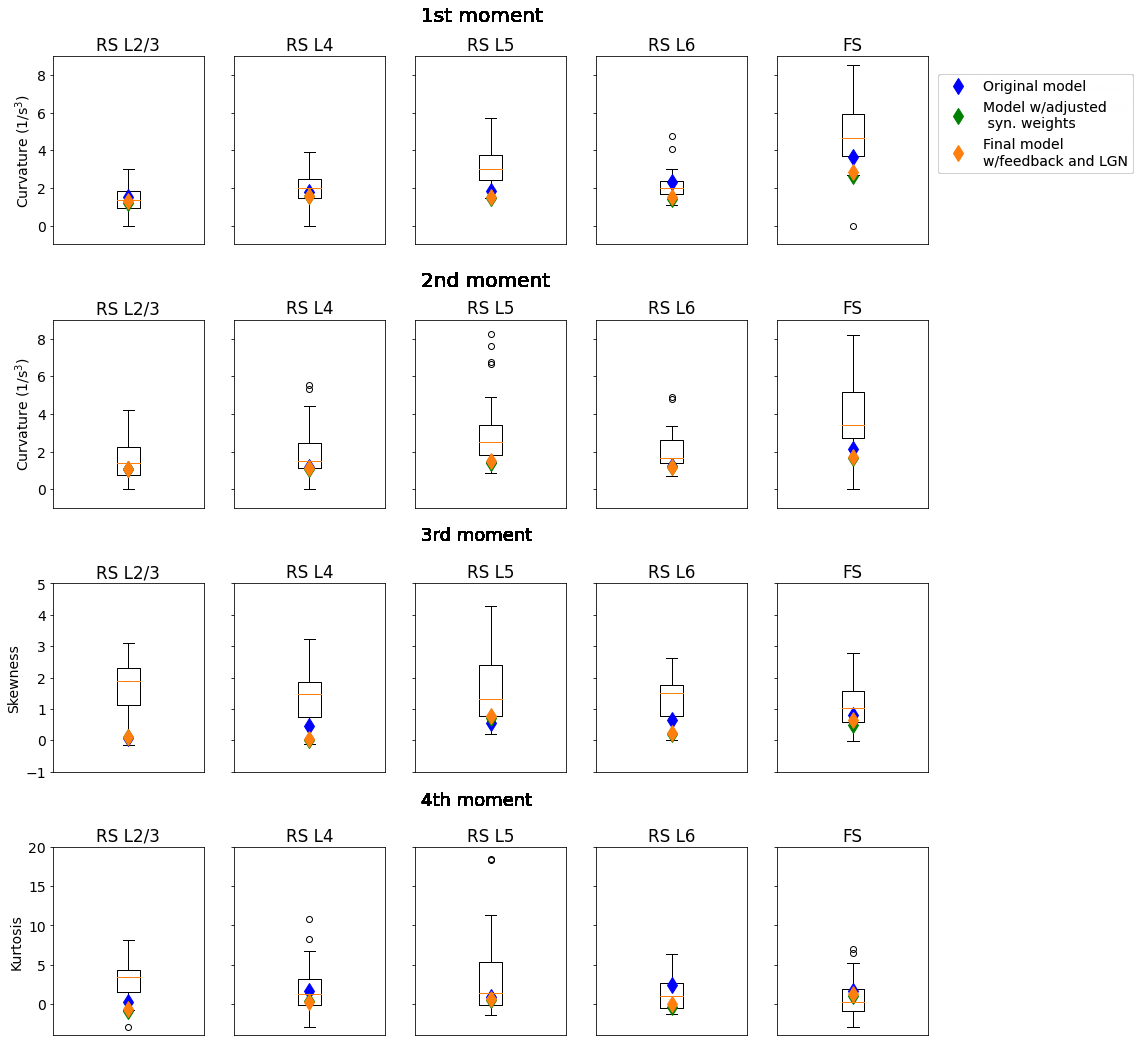

In [58]:
fig, axes = plt.subplots(nrows = 4, ncols = 5, figsize = (16,16), sharey = False)

for i, pop_names_moms in enumerate(sorted(list(pops_curv_moms.keys()))):
    if 'FS' in pop_names_moms:
        irow = int(pop_names_moms.split(' ')[1][0])-1
        icol = -1
    else:
        irow = int(pop_names_moms.split(' ')[2][0])-1
        if '2/3' in pop_names_moms:
            icol = int(pop_names_moms.split(' ')[1][3])-3
        else:
            icol = int(pop_names_moms.split(' ')[1][1])-3
            
    #if irow > 1:
    #    continue
        
    print(pop_names_moms, irow, icol)
    
    axes[irow,icol].boxplot(pops_curv_moms[pop_names_moms])
    
    axes[irow,icol].set_title(pop_names_moms.rsplit(' ', 2)[0])
    
for i, sim_pop_names_moms in enumerate(sorted(list(sims_curv_moms.keys()))[::-1]):
    sim_name = sim_pop_names_moms.split(' ')[0]
    if 'FS' in sim_pop_names_moms:
        irow = int(sim_pop_names_moms.split(' ')[2][0])-1
        icol = -1
    else:
        irow = int(sim_pop_names_moms.split(' ')[3][0])-1
        if '2/3' in sim_pop_names_moms:
            icol = int(sim_pop_names_moms.split(' ')[2][3])-3
        else:
            icol = int(sim_pop_names_moms.split(' ')[2][1])-3
            
    #if irow > 1:
    #    continue
        
    if irow == 0:
        axes[irow,icol].set_ylim([-1, 9])
        if icol == 0:
            axes[irow,icol].set_ylabel('Curvature (1/s$^3$)')
    elif irow == 1:
        axes[irow,icol].set_ylim([-1, 9])
        if icol == 0:
            axes[irow,icol].set_ylabel('Curvature (1/s$^3$)')
    elif irow == 2:
        axes[irow,icol].set_ylim([-1, 5])
        if icol == 0:
            axes[irow,icol].set_ylabel('Skewness')
    elif irow == 3:
        axes[irow,icol].set_ylim([-4, 20])
        if icol == 0:
            axes[irow,icol].set_ylabel('Kurtosis')
        
        
    if icol != 0:
        axes[irow,icol].set_yticklabels([])
        
    #print(sim_pop_names_moms, irow, icol)
    
    if irow == 0 and icol == 0:
        sim_label = sims_labels[sim_name]
    else:
        sim_label = None
    
    axes[irow,icol].plot(1, sims_curv_moms[sim_pop_names_moms], 'd', markersize = 12, color = sims_colors[sim_name], label = sim_label)
    
    fig.subplots_adjust(hspace = 0.4, left = 0.05, right = 0.81, bottom = 0.05, top = 0.9)
    
    axes[irow,icol].set_xticks([])
        
    plt.figtext(x = 0.37, y = 0.93, s = '1st moment', fontsize = 20,)
    plt.figtext(x = 0.37, y = 0.7, s = '2nd moment', fontsize = 20)
    plt.figtext(x = 0.37, y = 0.48, s = '3rd moment', fontsize = 18)
    plt.figtext(x = 0.37, y = 0.25, s = '4th moment', fontsize = 18)
    
    fig.legend(bbox_to_anchor = (0.99, 0.85))
    
    
    fig_name = 'curvature_first_two_moms_dist_'+sim_name+'.png'
    savepath = os.path.join(fig_dir, fig_name)

fig.savefig(savepath, facecolor='w')

FS 1st moment 0 -1
FS 2nd moment 1 -1
FS 3rd moment 2 -1
FS 4th moment 3 -1
RS L2/3 1st moment 0 0
RS L2/3 2nd moment 1 0
RS L2/3 3rd moment 2 0
RS L2/3 4th moment 3 0
RS L4 1st moment 0 1
RS L4 2nd moment 1 1
RS L4 3rd moment 2 1
RS L4 4th moment 3 1
RS L5 1st moment 0 2
RS L5 2nd moment 1 2
RS L5 3rd moment 2 2
RS L5 4th moment 3 2
RS L6 1st moment 0 3
RS L6 2nd moment 1 3
RS L6 3rd moment 2 3
RS L6 4th moment 3 3
old_model RS L6 4th moment 3 3
old_model RS L6 3rd moment 2 3
old_model RS L6 2nd moment 1 3
old_model RS L6 1st moment 0 3
old_model RS L5 4th moment 3 2
old_model RS L5 3rd moment 2 2
old_model RS L5 2nd moment 1 2
old_model RS L5 1st moment 0 2
old_model RS L4 4th moment 3 1
old_model RS L4 3rd moment 2 1
old_model RS L4 2nd moment 1 1
old_model RS L4 1st moment 0 1
old_model RS L2/3 4th moment 3 0
old_model RS L2/3 3rd moment 2 0
old_model RS L2/3 2nd moment 1 0
old_model RS L2/3 1st moment 0 0
old_model FS 4th moment 3 -1
old_model FS 3rd moment 2 -1
old_model FS 2nd m

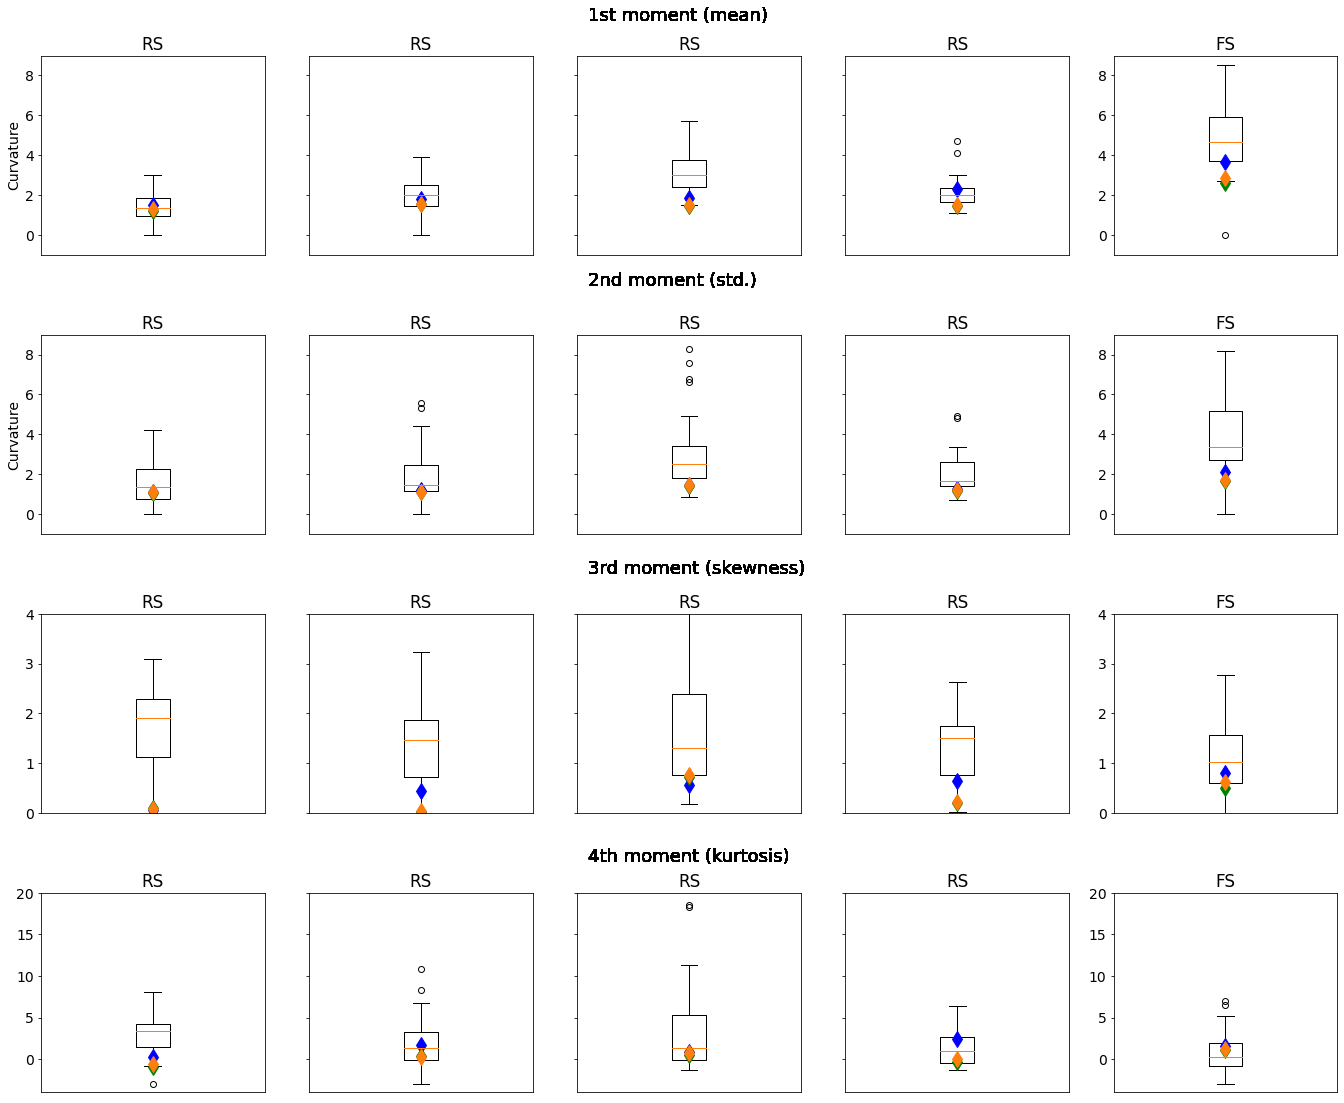

In [198]:
fig, axes = plt.subplots(nrows = 4, ncols = 5, figsize = (20,16))

for i, pop_names_moms in enumerate(sorted(list(pops_curv_moms.keys()))):
    if 'FS' in pop_names_moms:
        irow = int(pop_names_moms.split(' ')[1][0])-1
        icol = -1
    else:
        irow = int(pop_names_moms.split(' ')[2][0])-1
        if '2/3' in pop_names_moms:
            icol = int(pop_names_moms.split(' ')[1][3])-3
        else:
            icol = int(pop_names_moms.split(' ')[1][1])-3
        
    print(pop_names_moms, irow, icol)
    
    axes[irow,icol].boxplot(pops_curv_moms[pop_names_moms])
    
    axes[irow,icol].set_title(pop_names_moms.rsplit(' ', 3)[0])
    
for i, sim_pop_names_moms in enumerate(sorted(list(sims_curv_moms.keys()))[::-1]):
    sim_name = sim_pop_names_moms.split(' ')[0]
    if 'FS' in sim_pop_names_moms:
        irow = int(sim_pop_names_moms.split(' ')[2][0])-1
        icol = -1
    else:
        irow = int(sim_pop_names_moms.split(' ')[3][0])-1
        if '2/3' in sim_pop_names_moms:
            icol = int(sim_pop_names_moms.split(' ')[2][3])-3
        else:
            icol = int(sim_pop_names_moms.split(' ')[2][1])-3
    if irow == 0:
        axes[irow,icol].set_ylim([-1, 9])
        if icol == 0:
            axes[irow,icol].set_ylabel('Curvature')
    elif irow == 1:
        axes[irow,icol].set_ylim([-1, 9])
        if icol == 0:
            axes[irow,icol].set_ylabel('Curvature')
    elif irow == 2:
        axes[irow,icol].set_ylim([0, 4])
    elif irow == 3:
        axes[irow,icol].set_ylim([-4, 20])
        
    if icol > 0:
        axes[irow,icol].set_yticklabels([])
        
    print(sim_pop_names_moms, irow, icol)
    
    axes[irow,icol].plot(1, sims_curv_moms[sim_pop_names_moms], 'd', markersize = 12, color = sims_colors[sim_name], label = sims_labels[sim_name])
    
    fig.subplots_adjust(hspace = 0.4, left = 0.05, right = 0.95, bottom = 0.05, top = 0.95)
    
    axes[irow,icol].set_xticks([])
        
    plt.figtext(x = 0.43, y = 0.98, s = '1st moment (mean)', fontsize = 18)
    plt.figtext(x = 0.43, y = 0.75, s = '2nd moment (std.)', fontsize = 18)
    plt.figtext(x = 0.43, y = 0.5, s = '3rd moment (skewness)', fontsize = 18)
    plt.figtext(x = 0.43, y = 0.25, s = '4th moment (kurtosis)', fontsize = 18)
    
    fig_name = 'curvature_moms_dist_'+sim_name+'.png'
    savepath = os.path.join(fig_dir, fig_name)

    #fig.savefig(savepath, facecolor='w')

'old_model'

In [82]:
mom_nr = int(pop_names_moms.split(' ')[2][0])
pre_mom_nr

4

In [76]:
sorted(list(pops_curv_moms.keys()))

['FS 1st mom (mean)',
 'FS 2nd mom (std.)',
 'FS 3rd mom (skewness)',
 'FS 4th mom (kurtosis)',
 'RS L2/3 1st mom (mean)',
 'RS L2/3 2nd mom (std.)',
 'RS L2/3 3rd mom (skewness)',
 'RS L2/3 4th mom (kurtosis)',
 'RS L4 1st mom (mean)',
 'RS L4 2nd mom (std.)',
 'RS L4 3rd mom (skewness)',
 'RS L4 4th mom (kurtosis)',
 'RS L5 1st mom (mean)',
 'RS L5 2nd mom (std.)',
 'RS L5 3rd mom (skewness)',
 'RS L5 4th mom (kurtosis)',
 'RS L6 1st mom (mean)',
 'RS L6 2nd mom (std.)',
 'RS L6 3rd mom (skewness)',
 'RS L6 4th mom (kurtosis)']

In [73]:
sims_curv_moms

{'final_model RS L2/3 1st mom (mean)': [1.3149429567957347],
 'final_model RS L2/3 2nd mom (std.)': [1.0979184197587124],
 'final_model RS L2/3 3rd mom (skewness)': [0.09056928394962144],
 'final_model RS L2/3 4th mom (kurtosis)': [-0.6359573739529472],
 'final_model RS L4 1st mom (mean)': [1.5457011959493492],
 'final_model RS L4 2nd mom (std.)': [1.1014117730458135],
 'final_model RS L4 3rd mom (skewness)': [0.04954819962328523],
 'final_model RS L4 4th mom (kurtosis)': [0.24816620212737517],
 'final_model RS L5 1st mom (mean)': [1.5198518442645996],
 'final_model RS L5 2nd mom (std.)': [1.4738185559870678],
 'final_model RS L5 3rd mom (skewness)': [0.7667004749956352],
 'final_model RS L5 4th mom (kurtosis)': [0.6779991131766061],
 'final_model RS L6 1st mom (mean)': [1.5162224340694788],
 'final_model RS L6 2nd mom (std.)': [1.19156510533013],
 'final_model RS L6 3rd mom (skewness)': [0.22530270121049042],
 'final_model RS L6 4th mom (kurtosis)': [0.011172382369908807],
 'final_mod

In [49]:
sims_max_curv[session_id][pop_name].shape

(3268,)

In [45]:
 sims_max_curv[sim_name][pop_name]

array([3.72044924, 0.        , 2.26215031, ..., 2.24157907, 1.9240105 ,
       1.90911028])

In [39]:
pops_max_curv

{'RS L4': array([18.63515261,  2.21020459,  6.44287249,  0.        ,  3.34654505,
         0.        ,  3.7833935 ,  2.69518093,  0.97706564,  0.        ,
         0.        ,  3.31929697,  1.32480785,  8.60572495,  0.74970071,
         2.26114008,  7.24075588,  3.1460272 ,  3.70419452,  0.74970071,
         1.48367763,  1.48367763,  0.74970071,  0.        ,  3.1094554 ,
         0.74970071,  2.21240465,  0.75059293,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         2.80048108,  2.24321623,  0.74970071,  0.75059293,  3.52717058,
         3.06162046,  2.65909389,  5.43448379,  2.01092553,  4.31439308,
         2.45360561,  1.68600652,  2.78476133,  1.50029363,  6.04945852,
         4.2594148 ,  1.56573894,  2.83806045,  2.05846064,  1.49940142,
         2.21456227,  0.74970071,  1.70417416,  0.74970071,  0.74970071,
         0.74970071,  1.23749664,  2.71877

In [40]:
pops_lat_max_curv

{'RS L4': array([57., 40., 45., 36., 97., 67., 96., 55., 39., 53., 61., 77., 65.,
        72., 52., 93., 38., 74., 26., 29., 19., 97., 72., 54., 92., 14.,
         4., 56., 63., 55., 37., 24., 92., 68., 96., 60., 59., 18., 48.,
        21., 49., 37., 36., 41.,  4., 20., 32., 15., 26., 36., 43., 20.,
        34., 33., 37., 10., 76., 20., 32., 71., 37., 39., 29.,  4., 64.,
        55., 14., 49., 90., 21., 28., 24., 94., 86., 57., 25.,  0., 33.,
        78., 85.,  9., 51., 83.,  1., 31., 88., 10., 11., 34., 18., 23.,
        60., 14., 28., 65., 49., 79., 53.,  4., 63., 84., 92., 88., 35.,
        33., 15.,  1., 84., 60., 16.,  6.,  9., 82., 41.,  8., 30., 22.,
        72., 33., 24.,  5., 34., 25., 14.,  3., 11., 16., 27., 83., 73.,
        18., 87., 44., 16.,  4., 84., 91., 54., 41., 75., 32., 40., 21.,
        20., 82., 24., 82., 36., 35., 95., 73., 22., 18., 29., 16., 70.,
        43., 85., 87., 13.,  1., 82., 76., 24., 17., 44., 80., 59., 71.,
        44., 55., 28., 89., 68., 95., 11.,

In [730]:
sims_max_rate_change[sim_name][pop_name].shape

(14133,)

FS 0.17048073706508696
RS L2/3 0.33375302302237175
RS L4 0.2541424529741105
RS L5 0.21927265108216157
RS L6 0.29208138204813106


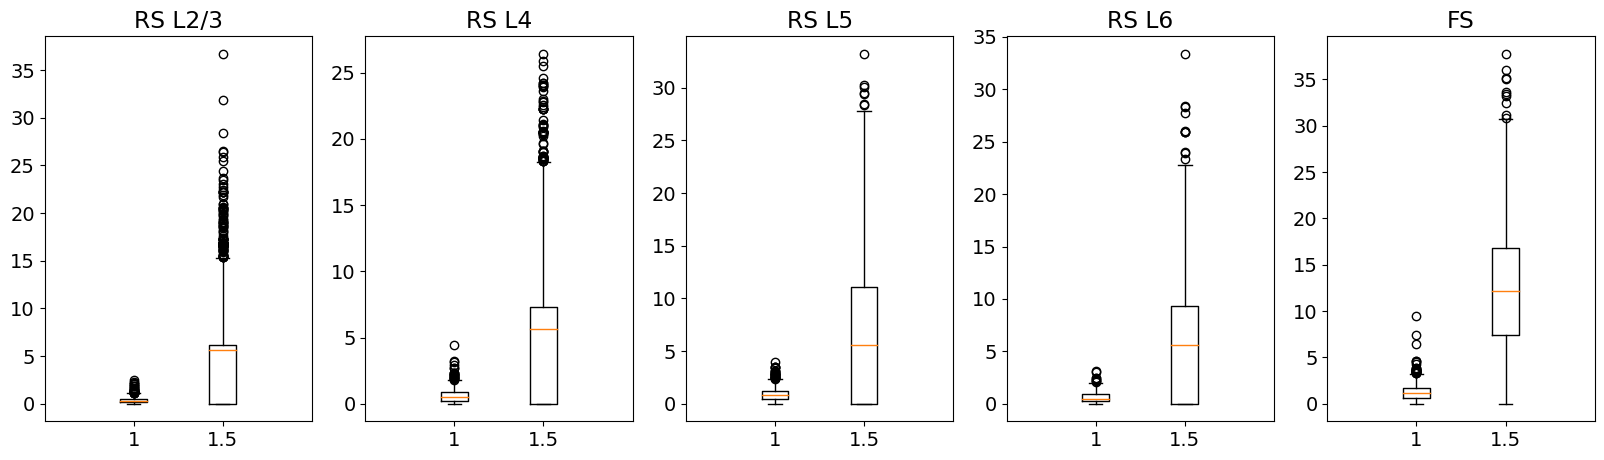

In [31]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,5))

for ipop, pop_name in enumerate(sorted(pops_max_rate_change.keys())):
    if 'FS' in pop_name:
        iplot = -1
        ax = axes[iplot]
    else:
        iplot = ipop - 1
        ax = axes[iplot]
        
    print(pop_name, np.nanmean(pops_max_rate_change[pop_name])/np.nanmean(pops_baseline_rate[pop_name], axis = 0))
        
    ax.boxplot(pops_max_rate_change[pop_name])
    
    ax.set_title(pop_name)
    
    for sim_name in sims_max_rate_change.keys():
        #ax.plot(1, sims_max_rate_change[sim_name][pop_name],  '*', markersize = 15, color = sims_colors[sim_name], label = sims_labels[sim_name])
        ax.boxplot(sims_max_rate_change[sim_name][pop_name], positions = [1.5])

FS 56.0
RS L2/3 50.0
RS L4 51.0
RS L5 56.0
RS L6 56.0


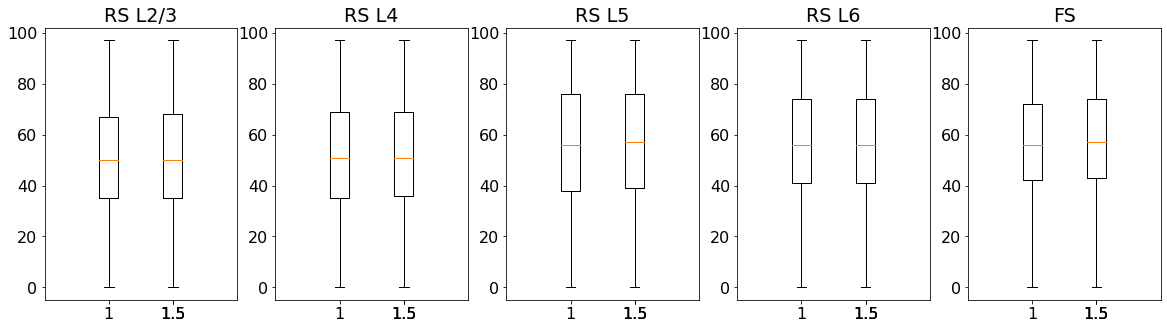

In [733]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,5))

for ipop, pop_name in enumerate(sorted(pops_lat_max_rate_change.keys())):
    if 'FS' in pop_name:
        iplot = -1
        ax = axes[iplot]
    else:
        iplot = ipop - 1
        ax = axes[iplot]
        
    print(pop_name, np.median(pops_lat_max_rate_change[pop_name]))
        
    ax.boxplot(pops_lat_max_rate_change[pop_name], showfliers = True)
    
    ax.set_title(pop_name)
    
    for sim_name in sims_lat_max_rate_change.keys():
        ax.boxplot(sims_lat_max_rate_change[sim_name][pop_name], positions = [1.5])
    
    

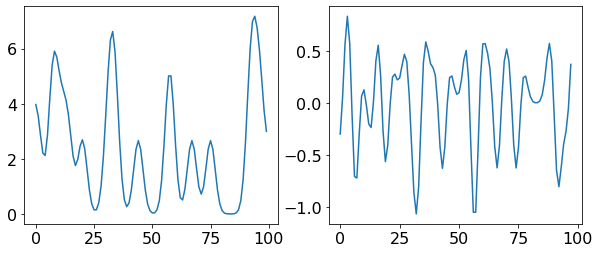

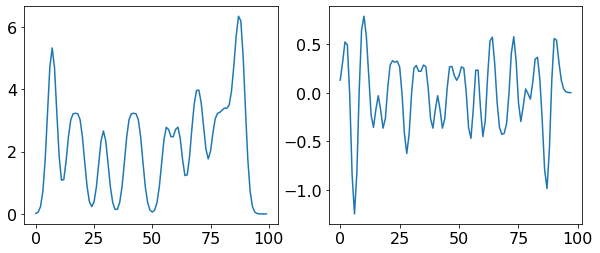

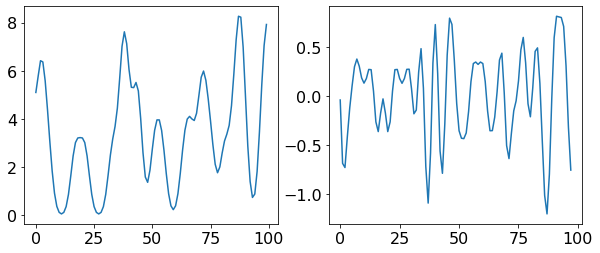

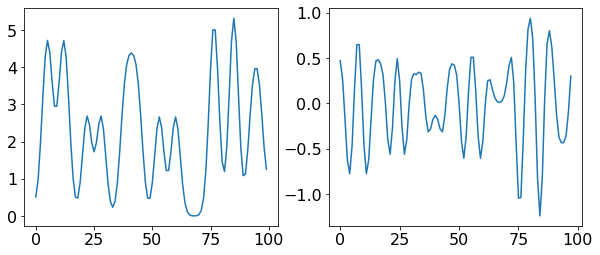

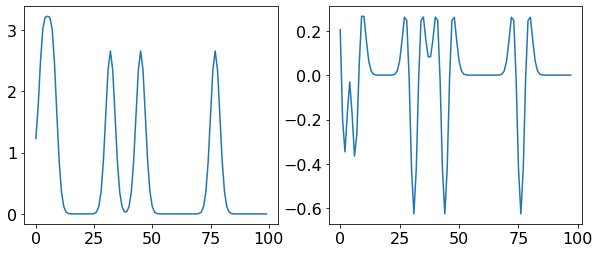

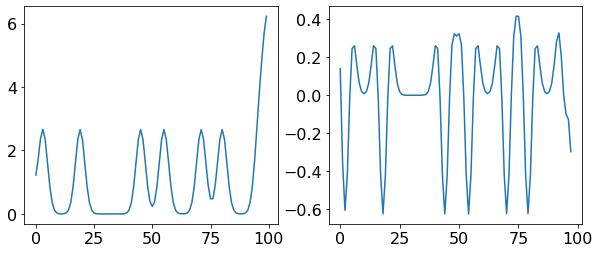

In [600]:
pop_name = 'RS L4'
fir_rates = np.mean(sessions_spike_trains_layer_pops[session_id][pop_name][:,:,tstim_onset:tstim_onset+100],axis = 1)
fir_rates = gaussian_filter(fir_rates, sigma = (0,2))*1E3

for icell in range(fir_rates.shape[0]):
    fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
    axes[0].plot(fir_rates[icell])
    axes[1].plot(np.diff(fir_rates[icell], n = 2))

In [22]:
all_spike_trains_layer_pops = dict()

all_spike_trains_layer_pops['RS L2/3'] = []
all_spike_trains_layer_pops['RS L4'] = []
all_spike_trains_layer_pops['RS L5'] = []
all_spike_trains_layer_pops['RS L6'] = []
all_spike_trains_layer_pops['FS'] = []

sessions_ncells_layer_pops = dict()

for session_id, spike_trains_layer_pops in sessions_spike_trains_layer_pops.items():
    ncells_layer_pops = dict()
    for pop_name, spike_trains in spike_trains_layer_pops.items():
        
        ncells_layer_pops[pop_name] = len(spike_trains)
        
        if len(spike_trains) == 0:
            continue
        elif len(all_spike_trains_layer_pops[pop_name]) == 0:
            print(pop_name)
            all_spike_trains_layer_pops[pop_name] = spike_trains
        else:
            all_spike_trains_layer_pops[pop_name] = np.concatenate([all_spike_trains_layer_pops[pop_name], \
                                                                   spike_trains])
            
    sessions_ncells_layer_pops[session_id] = ncells_layer_pops

RS L2/3
RS L4
RS L5
RS L6
FS


## Temporal dynamics

NameError: name 'fig_name' is not defined

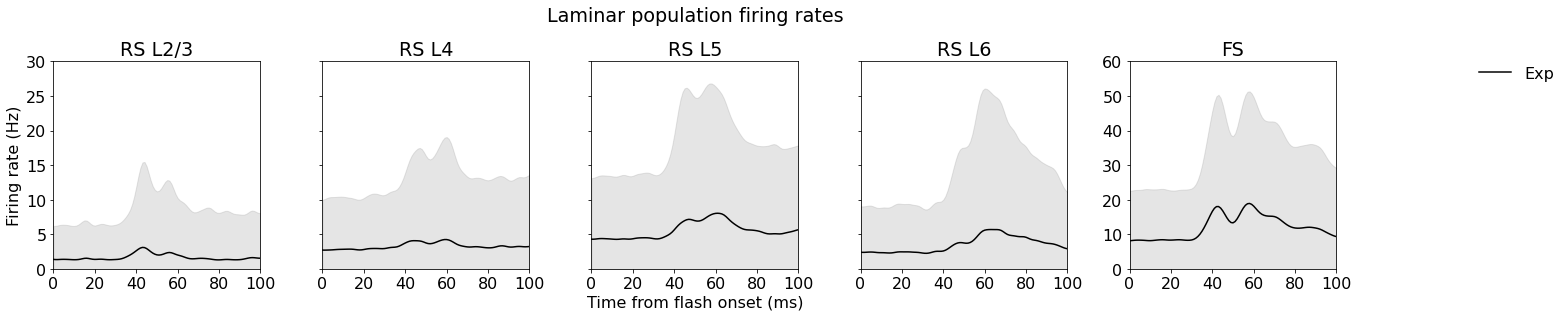

In [26]:
tstim_onset = 1000

fig, axes = plt.subplots(ncols = 5, figsize = (22,4.5))

fig.subplots_adjust(wspace = 0.3, left = 0.04, right = 0.85, bottom = 0.18, top = 0.82)

'''sim_names = list(sims_spike_trains_layer_pops.keys())
sim_names.insert(0, sim_names.pop())'''

iplot = 0
for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
    
    if iplot == 4:
        axes[iplot].set_ylim([0, 60])
    else:
        axes[iplot].set_ylim([0, 30])
        if iplot == 0:
            
            fir_rate_label = 'Exp'
            std_label = '±1$\sigma$'
            
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels(np.arange(0,30+5,5))
        else:
            fir_rate_label = None
            std_label = None
            sim_labels = [None, None]
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels([])
    
    pop_fir_rate = np.mean(np.mean(all_spike_trains_pop, axis = 0), axis = 0) * 1E3
    
    #all_spike_trains_pop_rs = all_spike_trains_pop.reshape(all_spike_trains_pop.shape[0]*\
    #                                                       all_spike_trains_pop.shape[1],-1)
    
    fir_rate_trial_avg = np.mean(all_spike_trains_pop, axis = 1)
    
    #std_time_resolved =  np.std(all_spike_trains_pop_rs, axis = 0)[tstim_onset:tstim_onset+100]*1E3
    
    std_of_trial_avg =  np.std(fir_rate_trial_avg, axis = 0)[tstim_onset:tstim_onset+105]*1E3
    
    std_of_trial_avg = gaussian_filter(std_of_trial_avg, sigma = 2)

    
    
    fir_rate_plot = gaussian_filter(pop_fir_rate, sigma = 2)[tstim_onset:tstim_onset+105]
    
    time = np.arange(0, 105, 1)
    
    axes[iplot].plot(time, fir_rate_plot, color = 'k', label = fir_rate_label)
    
    axes[iplot].fill_between(x = time, y1 = fir_rate_plot-std_of_trial_avg, \
                             y2 = fir_rate_plot+std_of_trial_avg, color = (0.5,0.5,0.5), 
                             alpha = 0.2)
    
    '''for isim, sim_name in enumerate(sim_names[::-1]):
        
        sim_spike_trains_layer_pop = sims_spike_trains_layer_pops[sim_name][pop_name]

        sim_pop_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop[:, :10, \
                                    tstim_onset_sim:tstim_onset_sim+105], axis = 0), axis = 0)*1E3

        sim_fir_rate_plot = gaussian_filter(sim_pop_fir_rate, sigma = 2)

        if iplot == 0:
            sim_label = sims_labels[sim_name]
            #sim_label = sim_name
        else:
            sim_label = None
        
        axes[iplot].plot(time, sim_fir_rate_plot, color = sims_colors[sim_name], label = sim_label)
        #axes[iplot].plot(time, sim_fir_rate_plot, label = sim_label)'''

    
    
            
    axes[iplot].set_xticks(np.arange(0,100+20,20))
    axes[iplot].set_xticklabels(np.arange(0,100+20,20))
    
    axes[iplot].set_xlim([0,100])
    
    axes[iplot].set_title(pop_name)
    iplot += 1
    
axes[0].set_ylabel('Firing rate (Hz)')

fig.suptitle('Laminar population firing rates', y = 0.99, x = 0.445)
    
#plt.figtext(s = 'Time from flash onset (ms)', x = 0.43, y = 0.05)
axes[2].set_xlabel('Time from flash onset (ms)')
    
fig.legend(bbox_to_anchor = (0.99, 0.82), frameon = False)
#print(sim_name)
#fig_name = 'exp_and_sim_pop_fir_rate_'+sim_name+'.png'

savepath = os.path.join('Figures', 'Figure_6', fig_name)

#fig.savefig(savepath, facecolor = 'w')

### KS-similarity

- KS-similarity between distribution of firing rates across cells in simulations and distribution of firing rates across cells from all animals.
- Note: You can load the pre-computed KS-similarities for all animals in cell below. If you are interested in how the KS-similarity is calculated, go to the notebook titled "Figure_2_and_3"

### Load data

In [37]:
filename = 'exp_ks_simil_mode_w-RS-FS-naming.npy'
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'KS-similarity', filename)

sessions_mode_ks_simil = np.load(loadpath, allow_pickle = True)[()]

In [38]:
mode_ks_simil_all = dict()

for mode, sessions_ks_simil in sessions_mode_ks_simil.items():
    ks_simil_all = dict()
    ks_simil_all['RS L2/3'] = []
    ks_simil_all['RS L4'] = []
    ks_simil_all['RS L5'] = []
    ks_simil_all['RS L6'] = []
    ks_simil_all['FS'] = []

    for session_id, ks_simil_pops in sessions_ks_simil.items():

        for pop_name, ks_simil in ks_simil_pops.items():
            if ks_simil == -1:
                continue
            elif pop_name == 'E23':
                pop_name = 'E2/3'

            ks_simil_all[pop_name].append(ks_simil)
            
    mode_ks_simil_all[mode] = ks_simil_all

### KS-similarity between model and experiments

In [39]:
sims_ks_simil_modes = dict()

for sim_name, sim_spike_trains_layer_pops in sims_spike_trains_layer_pops.items():
    print(sim_name)

    sim_ks_simil_modes = dict()

    for mode in ['peak', 'baseline', 'post-peak']:

        #print(mode)

        if mode == 'peak':
            t_start_exp = tstim_onset+35
            t_stop_exp = tstim_onset+60

            t_start_sim = tstim_onset_sim+35
            t_stop_sim = tstim_onset_sim+60
        elif mode == 'baseline':
            t_start_exp = 750
            t_stop_exp = tstim_onset

            t_start_sim = 0
            t_stop_sim = tstim_onset_sim
        elif mode == 'post-peak':
            t_start_exp = tstim_onset+60
            t_stop_exp = tstim_onset+100

            t_start_sim = tstim_onset_sim+60
            t_stop_sim = tstim_onset_sim+100

        sim_ks_simil_pop = dict()
        for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
            print(pop_name, sim_spike_trains_layer_pops[pop_name].shape[0])

            exp_spike_trains_pop = all_spike_trains_pop[:,:,t_start_exp:t_stop_exp]

            sim_spike_trains_layer_pop = sim_spike_trains_layer_pops[pop_name][:,:ntrials_sim,t_start_sim:t_stop_sim]

            sim_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop, axis = -1), axis = -1)

            exp_fir_rate = np.mean(np.mean(exp_spike_trains_pop, axis = -1), axis = -1)

            ks_dist = stats.ks_2samp(exp_fir_rate, sim_fir_rate)[0]

            ks_simil_temp = 1-ks_dist

            sim_ks_simil_pop[pop_name] = ks_simil_temp

        sim_ks_simil_modes[mode] = sim_ks_simil_pop
        
    sims_ks_simil_modes[sim_name] = sim_ks_simil_modes

final_model
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
intermediate_model
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
old_model
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268


In [40]:
for sim_name, ks_simil_modes in sims_ks_simil_modes.items():
    for mode, ks_simil in ks_simil_modes.items():
        print(sim_name, mode, np.round(np.mean(np.array(list(ks_simil.values()))), 2))

final_model peak 0.7
final_model baseline 0.77
final_model post-peak 0.68
intermediate_model peak 0.73
intermediate_model baseline 0.79
intermediate_model post-peak 0.7
old_model peak 0.6
old_model baseline 0.67
old_model post-peak 0.58


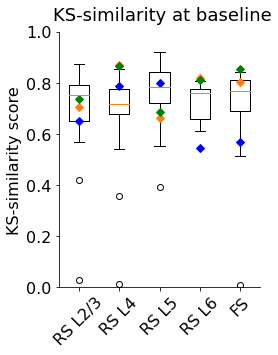

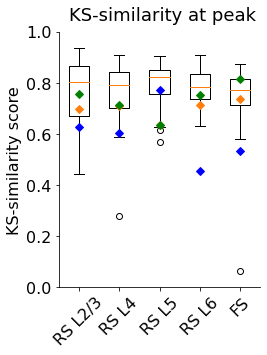

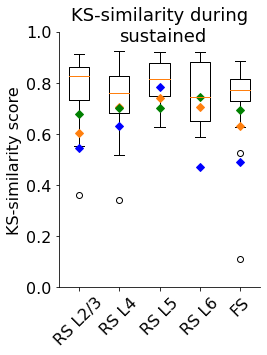

In [41]:
for mode in ['baseline', 'peak', 'post-peak']:

    fig, ax = plt.subplots(ncols = 1, figsize = (4,5), sharey = True)

    fig.subplots_adjust(wspace = 0.3, left = 0.22, right = 0.92, bottom = 0.2, top = 0.91)

    ks_simil_all = mode_ks_simil_all[mode]

    ipop = 0
    for pop_name, ks_simil_pop in ks_simil_all.items():
        ax.boxplot(ks_simil_pop, positions = [0.3*ipop])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        for sim_name, sim_ks_simil_modes in sorted(sims_ks_simil_modes.items()):

            #if '24' in sim_name:
            #    continue

            sim_ks_simil_pop = sim_ks_simil_modes[mode][pop_name]

            if ipop == 0:
                sim_label = sims_labels[sim_name]
                #sim_label = sim_name
            else:
                sim_label = None

            ax.plot(0.3*ipop, sim_ks_simil_pop, 'D', color = sims_colors[sim_name], label = sim_label)

        ipop += 1


    ax.set_xticklabels(list(ks_simil_all.keys()), rotation = 45)

    #fig.legend()

    ax.set_ylim([0.0, 1])
    ax.set_xlim([0-0.3/2,0.3*(ipop-1/2)])
    ax.set_ylabel('KS-similarity score')

    if mode == 'baseline':
        mode_title = 'at baseline'
    elif mode == 'peak':
        mode_title = 'at peak'
    elif mode == 'post-peak':
        mode_title = 'during \nsustained'

    fig.suptitle('KS-similarity '+mode_title, x = 0.58, y = 0.98, fontsize = 18)

    #fig.legend(bbox_to_anchor = (1.5,0.9))

    fig_name = 'KS-similarity-at-'+mode+'-'+sim_name+'.png'
    #savepath = os.path.join('Figures', 'Supplementary_figures', fig_name)
    savepath = os.path.join(fig_dir, fig_name)


    #fig.savefig(savepath, facecolor = 'w')

## Correlation

- Correlation between trial-averaged population firing rates
- Note: You can load the pre-computed correlation for all animals in cells further below. You can go to the notebook titled "Figure_2_and_3" to see how the calculation is done.

### Load data

In [42]:
filename = 'exp_corr_fir_rate-w-RS-FS-naming.npy'
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'correlation', filename)

sessions_corr_fir_rate = np.load(loadpath, allow_pickle = True)[()]

In [43]:
corr_fir_rates_all = dict()
corr_fir_rates_all['RS L2/3'] = []
corr_fir_rates_all['RS L4'] = []
corr_fir_rates_all['RS L5'] = []
corr_fir_rates_all['RS L6'] = []
corr_fir_rates_all['FS'] = []

for session_id, corr_fir_rate_pops in sessions_corr_fir_rate.items():

    for pop_name, corr_fir_rates in corr_fir_rate_pops.items():
        if corr_fir_rates == -1:
            continue
        elif pop_name == 'E23':
            pop_name = 'E2/3'

        corr_fir_rates_all[pop_name].append(corr_fir_rates)

### Correlation between sim and exp trial avg firing rate

In [44]:
t_start_exp = tstim_onset
t_stop_exp = tstim_onset+100

t_start_sim = tstim_onset_sim
t_stop_sim = tstim_onset_sim+100

sims_corr_pop_fir_rates = dict()
for sim_name, sim_spike_trains_layer_pops in sims_spike_trains_layer_pops.items():
    sim_corr_pop_fir_rates = dict()
    for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
        print(pop_name)

        exp_spike_trains_pop = all_spike_trains_pop[:,:,t_start_exp:t_stop_exp]

        sim_spike_trains_layer_pop = sim_spike_trains_layer_pops[pop_name][:,:ntrials_sim,t_start_sim:t_stop_sim]

        sim_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop, axis = 0), axis = 0)

        exp_fir_rate = np.mean(np.mean(exp_spike_trains_pop, axis = 0), axis = 0)

        corr, p = stats.pearsonr(exp_fir_rate, sim_fir_rate)
        
        #corr = np.dot(sim_fir_rate, exp_fir_rate) / (np.linalg.norm(sim_fir_rate)*np.linalg.norm(exp_fir_rate))

        print(sim_name, pop_name, 'r = ', np.round(corr, 2), 'p =', np.round(p,4))
        
        sim_corr_pop_fir_rates[pop_name] = corr
        
    sims_corr_pop_fir_rates[sim_name] = sim_corr_pop_fir_rates

RS L2/3
final_model RS L2/3 r =  0.36 p = 0.0003
RS L4
final_model RS L4 r =  0.64 p = 0.0
RS L5
final_model RS L5 r =  0.69 p = 0.0
RS L6
final_model RS L6 r =  0.87 p = 0.0
FS
final_model FS r =  0.77 p = 0.0
RS L2/3
intermediate_model RS L2/3 r =  0.49 p = 0.0
RS L4
intermediate_model RS L4 r =  0.63 p = 0.0
RS L5
intermediate_model RS L5 r =  0.71 p = 0.0
RS L6
intermediate_model RS L6 r =  0.87 p = 0.0
FS
intermediate_model FS r =  0.76 p = 0.0
RS L2/3
old_model RS L2/3 r =  0.38 p = 0.0001
RS L4
old_model RS L4 r =  0.62 p = 0.0
RS L5
old_model RS L5 r =  0.76 p = 0.0
RS L6
old_model RS L6 r =  0.89 p = 0.0
FS
old_model FS r =  0.8 p = 0.0


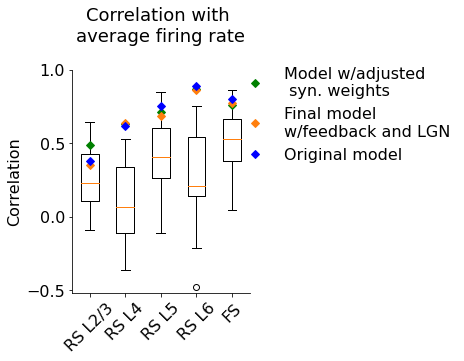

In [45]:
fig, ax = plt.subplots(ncols = 1, figsize = (6.5,5), sharey = True)

fig.subplots_adjust(left = 0.16, right = 0.54, bottom = 0.18, top = 0.8)

ipop = 0
for pop_name, corr_fir_rate_pop in corr_fir_rates_all.items():
    ax.boxplot(corr_fir_rate_pop, positions = [0.3*ipop])
        
    for sim_name in sim_names[::-1]:
        
        sim_corr_pop_fir_rates = sims_corr_pop_fir_rates[sim_name]
        
        if ipop == 0:
            sim_label = sims_labels[sim_name]
        else:
            sim_label = None
            
        ax.plot(0.3*ipop, sim_corr_pop_fir_rates[pop_name], 'D', color = sims_colors[sim_name], label = sim_label)

    ipop+=1

    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim([-.52, 1])
ax.set_ylabel('Correlation')

ax.set_title('Correlation with \naverage firing rate', x = 0.5, y = 1.1, fontsize = 18)


ax.set_xlim([0-0.3/2,0.3*(ipop-1/2)])
ax.set_xticklabels(list(corr_fir_rates_all.keys()), rotation = 45)

fig.legend(bbox_to_anchor = (1.0, 0.85), frameon=False)
    
fig_name = 'correlation-0-100ms-'+sim_name+'.png'
savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### LFP and CSD

In [46]:

#filename = 'cortical_depth_'+str(session_id)+'.csv'
#loadpath = os.path.join(exp_meta_data_dir, 'probes_cortical_depths', filename)
sessions_df_depth = dict()
loadpaths = sorted(glob(os.path.join(exp_meta_data_dir, 'probes_cortical_depths', '*')))
for loadpath in loadpaths:
    session_id = loadpath.split('/')[-1].split('.')[0].split('_')[-1]
    df_depth = pd.read_csv(loadpath, sep=' ')
    df_depth = df_depth.set_index('id')
    sessions_df_depth[session_id] = df_depth


In [47]:
session_id = list(sessions_df_depth.keys())[1]

channel_step_exp = 5
depth_ticks_exp = np.arange(0, len(channels_vert_pos), channel_step_exp)
depth_step_exp = channel_step_exp*np.diff(channels_vert_pos)[0]
depth_ticklabels_exp = np.arange(channels_vert_pos[0], channels_vert_pos[-1]+depth_step_exp, depth_step_exp) 


time_start_label_exp = 0
time_stop_label_exp = 100
time_step_label_exp = 20
time_ticklabels_exp = np.arange(time_start_label_exp, time_stop_label_exp+time_step_label_exp, time_step_label_exp)
sf = 1250
time_tick_step_exp = int(time_step_label_exp*sf/1E3)
time_ticks_exp = np.arange(0, sessions_csd_trial_avg[session_id].shape[-1]+time_tick_step_exp, time_tick_step_exp)

## PCA on trial averaged CSD

### Interpolate and normalize

#### Exp

In [48]:
sessions_csd_trial_avg_interp = dict()
sessions_sinks_trial_avg_interp = dict()
sessions_sources_trial_avg_interp = dict()

sp_len = 30; t_len = 100
for i_sess, session_id in enumerate(sessions_csd_trial_avg_short.keys()):
    csd_trial_avg = sessions_csd_trial_avg_short[session_id]
    
    sinks_interp = np.zeros((sp_len, t_len))
    sources_interp = np.zeros((sp_len, t_len))
    
    z = csd_trial_avg
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)
    
    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0
    
    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])
    
    
    sessions_csd_trial_avg_interp[session_id] = csd_interp/np.abs(csd_interp).max()
    sessions_sinks_trial_avg_interp[session_id] = sinks_interp/sinks_interp.sum()
    sessions_sources_trial_avg_interp[session_id] = sources_interp/sources_interp.sum()

### Doing the PCA

In [49]:
csd_trial_avg_interp_grand = np.array(list(sessions_csd_trial_avg_interp.values()))
csd_trial_avg_interp_grand = csd_trial_avg_interp_grand.reshape(csd_trial_avg_interp_grand.shape[0], 
                        csd_trial_avg_interp_grand.shape[1]*csd_trial_avg_interp_grand.shape[2])

n_components = csd_trial_avg_interp_grand.shape[0]
pca = PCA(n_components=n_components)

pca.fit(csd_trial_avg_interp_grand.T)

PCA(n_components=44)

In [50]:
print(pca.explained_variance_ratio_)

[5.03910403e-01 1.38802335e-01 6.61447376e-02 5.30769109e-02
 3.32573348e-02 2.73709661e-02 2.26092151e-02 2.01221678e-02
 1.61550654e-02 1.30111692e-02 1.20868404e-02 1.03926962e-02
 9.41570153e-03 9.14499572e-03 6.42395357e-03 5.56246257e-03
 5.29747046e-03 4.34798311e-03 4.01254791e-03 3.89161973e-03
 3.56123120e-03 3.07196030e-03 2.93426248e-03 2.76032325e-03
 2.34272899e-03 2.23431932e-03 1.97779675e-03 1.81658373e-03
 1.61282564e-03 1.44059109e-03 1.35826902e-03 1.30787127e-03
 1.15977315e-03 1.09017860e-03 9.22867875e-04 8.02214636e-04
 7.85934912e-04 7.20523152e-04 6.29956384e-04 5.91210127e-04
 5.30757358e-04 4.64248098e-04 4.43407897e-04 4.03589006e-04]


#### Reshape components into CSD shape with (space, time) interpolated dimensions

In [51]:
# Look at first four components
recon = np.empty((4, sp_len, t_len))
for compNr in range(4):
    recon[compNr] = np.dot(pca.components_[compNr], csd_trial_avg_interp_grand).reshape(sp_len, t_len)*\
                        pca.explained_variance_ratio_[compNr]

### Split sources and sinks and do wasserstein distance calculation from trial-averaged CSD in individual animals to PC 1 CSD

In [52]:
recon_sinks_list = np.empty_like(recon)
recon_sources_list = np.empty_like(recon)

for compNr in range(recon.shape[0]):
    recon_temp = recon[compNr]
    mask_sinks = recon_temp < 0
    mask_sources = recon_temp > 0
    
    sinks_recon_temp = np.zeros_like(recon_temp)
    sinks_recon_temp[mask_sinks] = np.abs(recon_temp[mask_sinks])
    sources_recon_temp = np.zeros_like(recon_temp)
    sources_recon_temp[mask_sources] = np.abs(recon_temp[mask_sources])
    
    recon_sinks_list[compNr] = sinks_recon_temp/sinks_recon_temp.sum()
    recon_sources_list[compNr] = sources_recon_temp/sources_recon_temp.sum()

In [53]:
sinks_mice = np.array(list(sessions_sinks_trial_avg_interp.values()))
sources_mice = np.array(list(sessions_sources_trial_avg_interp.values()))

In [54]:
n_animals = len(sinks_mice)
# for sinks
compNr = 0 # selecting PC 1 component
sink_matrix_recon_exp, M_sink_recon_exp, G0_sink_recon_exp, x_s, x_t = compute_dist_matrix_exp(sinks_mice[:n_animals], 
                                                                             recon_sinks_list[compNr:compNr+1],
                                                                            mode = 'exp_to_reco')

# for sources
source_matrix_recon_exp, M_source_recon_exp, G0_source_recon_exp, x_s, x_t = compute_dist_matrix_exp(sources_mice[:n_animals], 
                                                                             recon_sources_list[compNr:compNr+1],
                                                                            mode = 'exp_to_reco')

# sum wasserstein distances calculated for sinks and sources into one matrix of Wasserstein distances from 
# individual animals to PC 1 CSD
dist_matrix_recon_exp = sink_matrix_recon_exp+source_matrix_recon_exp

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:47<00:00,  1.09s/it]


### WD between model CSD and PC 1 CSD

#### Interpolate and normalize

In [55]:
sims_sinks = dict()
sims_sources = dict()

sims_csd_interp = dict()

n_chans_in_cortex_sim = 21
for sim_name in csd_sims.keys():
    z = csd_sims[sim_name]['trial_avg'][:n_chans_in_cortex_sim,tstim_onset_sim:tstim_onset_sim+100]
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)

    sims_csd_interp[sim_name] = csd_interp

    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0

    sinks_interp = np.zeros_like(csd_interp)
    sources_interp = np.zeros_like(csd_interp)

    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])

    sims_sinks[sim_name] = sinks_interp / sinks_interp.sum()
    sims_sources[sim_name] = sources_interp / sources_interp.sum()


    sims_sinks_list = np.array(list(sims_sinks.values()))
    sims_sources_list = np.array(list(sims_sources.values()))

In [56]:
compNr = 0

dist_matrix_recon_sims = dict()

for sim_name in sims_sinks.keys():
    sink_matrix_recon_sim, M_sink_recon_sim, G0_sink_recon_sim, x_s, x_t = compute_dist_matrix_exp(
                                                                                recon_sinks_list[compNr:compNr+1], 
                                                                                [sims_sinks[sim_name]],
                                                                                mode = 'sim_to_recon')
    
    source_matrix_recon_sim, M_source_recon_sim, G0_source_recon_sim, x_s, x_t = compute_dist_matrix_exp(
                                                                            recon_sources_list[compNr:compNr+1], 
                                                                            [sims_sources[sim_name]],
                                                                            mode = 'sim_to_recon')
    
    dist_matrix_recon_sims[sim_name] = sink_matrix_recon_sim + source_matrix_recon_sim
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


In [57]:
sim_names = list(dist_matrix_recon_sims.keys())

['intermediate_model', 'old_model', 'final_model']
intermediate_model
old_model
final_model


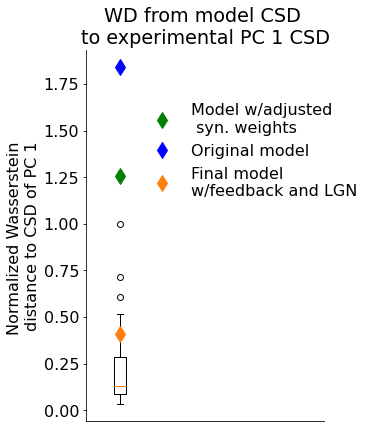

In [58]:
fig = plt.figure(figsize = (5.5,6))

ax = fig.add_subplot(1,1,1)

fig.subplots_adjust(left = 0.2, right = 0.8, bottom = 0.03, top = 0.89)

bp1 = ax.boxplot(x = dist_matrix_recon_exp[:,compNr]/dist_matrix_recon_exp[:,compNr].max(), positions = [1], widths = [0.07], patch_artist = True, \
                         boxprops=dict(facecolor="white"))


sim_names = sorted(list(dist_matrix_recon_sims.keys()))
sim_names = sim_names[1:] + [sim_names[0]]
print(sim_names)

for isim, sim_name in enumerate(sim_names):
    print(sim_name)

    ax.plot(1, dist_matrix_recon_sims[sim_name]/dist_matrix_recon_exp[:,compNr].max(), 'd', markersize = '12', color = sims_colors[sim_name], label = sims_labels[sim_name])

ax.set_xticks([])
ax.set_ylabel('Normalized Wasserstein \ndistance to CSD of PC 1')
#ax.set_ylabel('PDF')

ax.set_xlim([0.8, 2.2])

fig.legend(bbox_to_anchor = (0.92,0.8), frameon=False)

ax.set_title('WD from model CSD \nto experimental PC 1 CSD')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#fig_name = 'smooth_pdf_WD_distr_animals_to_PC1.png'

fig_name = 'WD_distr_exp_and_sim_to_PC1_'+sim_name+'.png'

savepath = os.path.join('Figures', 'Figure_6', fig_name)

#fig.savefig(savepath, facecolor='w')